### Currently, this notebook is used for:
    - loading the sfMix* experiment series in python format
    - plotting responses
    - testing various fits/analyses

### Set up

In [1]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses

%matplotlib inline 

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

## fixed
conDig = 3; # round contrast to the 3rd digit
# at CNS
basePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/';
# personal mac
# basePath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/';

## edit
expDir   = 'V1/';
fullWaveform = 0;
which_cell = 2; # which cell - index will be which_cell - 1

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();
expInd, expType = hf.get_exp_ind(dataPath, dataList['unitName'][which_cell-1])

In [2]:
expInd, dataList['unitName'][which_cell-1], expType

(5, 'm676p3l6', 'sfMixHalfInt')

Now, load the rvc/phFits, if applicable, and prepare to load the 

In [3]:
# rvcFits  = hf.get_rvc_fits(dataPath, expInd, which_cell)
# phFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName='phAdvFits')

if fullWaveform:
    waveStr = '_fullWave'
else:
    waveStr = '';

In [4]:
cellStruct = np.load(dataPath + dataList['unitName'][which_cell-1] + '_sfm' + waveStr + '.npy', encoding='latin1').item();
data = cellStruct['sfm']['exp']['trial'];

In [5]:
data.keys()

dict_keys(['num', 'blockID', 'duration', 'spikeTimes', 'spikeCount', 'fullWaves', 'f1', 'sf', 'tf', 'ori', 'ph', 'con', 'total_con', 'num_comps', 'cent_sf'])

In [6]:
np.unique(data['num_comps']), np.unique(data['total_con'])

(array([0, 1, 3, 5, 7], dtype=uint8),
 array([0.05      , 0.0727    , 0.1057    , 0.1538    , 0.2236    ,
        0.32362372, 0.3252    , 0.46915451, 0.4706078 , 0.47070731,
        0.4729    , 0.68084215, 0.68240656, 0.68466518, 0.6877    ,
        0.98959614, 0.99187   , 0.99515288, 1.        ,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]))

A quick look at spikes versus f1 power, and a check of my fourier analysis of the data

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


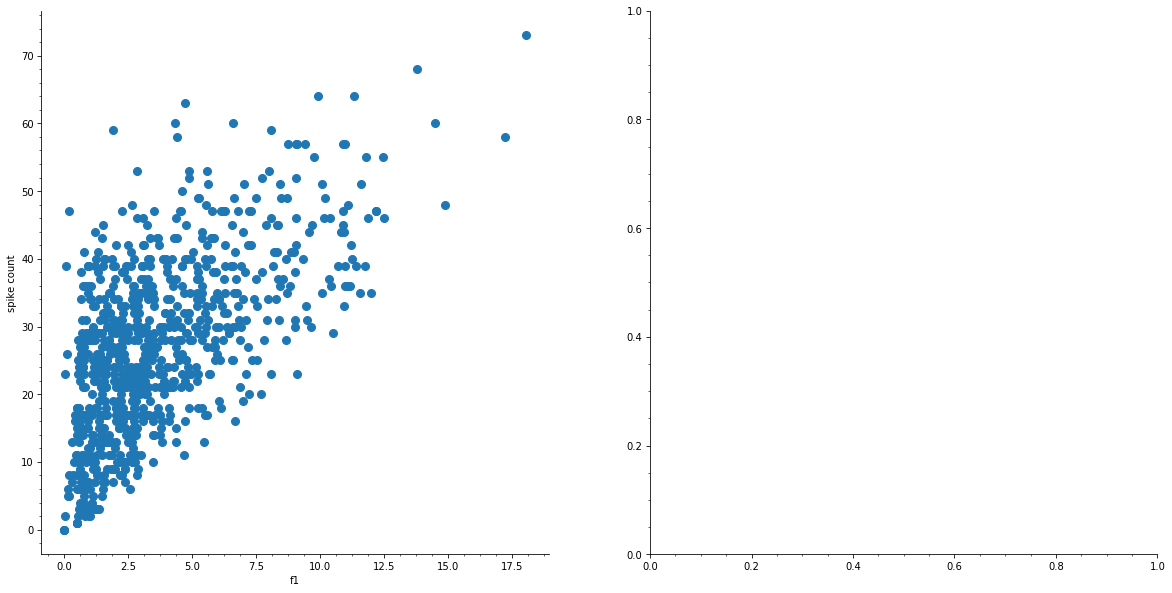

In [7]:
f, ax = plt.subplots(1, 2, figsize=(20, 10));
ax[0].plot(np.abs(data['f1']), np.abs(data['spikeCount']), 'o');
ax[0].set_xlabel('f1');
ax[0].set_ylabel('spike count');

if 'power_f1' in data:
    zzz = [x[0] if np.all(~np.isnan(x)) else x for x in data['power_f1']] 
    # get the first value of each power_f1 array to compare to the values expo gave
    ax[1].plot(np.abs(data['f1']), np.abs(zzz), 'o');
    ax[1].set_xlabel('f1 - expo');
    ax[1].set_ylabel('f1 - me');


### Organize data
#### determine contrasts, center spatial frequency, dispersions

In [8]:
data = cellStruct['sfm']['exp']['trial'];

resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = hf.tabulate_responses(data, expInd);

all_disps = stimVals[0];
all_cons = stimVals[1];
all_sfs = stimVals[2];

nCons = len(all_cons);
nSfs = len(all_sfs);
nDisps = len(all_disps);

#### Unpack responses

In [9]:
respMean = resp[0];
respStd = resp[1];
predMean = resp[2];
predStd = resp[3];
# f1Mean = resp[4];
# f1Std = resp[5];
# predF1mean = resp[6];
# predF1std = resp[7];
rM_summary = np.reshape([np.sum(x) for x in respMean.flatten()], respMean.shape)
rS_summary = np.reshape([np.sqrt(np.sum(np.square(x))) for x in respStd.flatten()], respStd.shape)

#### Load descriptive model fits

In [10]:
try:
    descrFits = np.load(dataPath + 'descrFits.npy', encoding = 'latin1').item();
    descrFits = descrFits[which_cell-1]['params']; # just get this cell
except:
    descrFits = None;

### Plots

#### Plots by dispersion

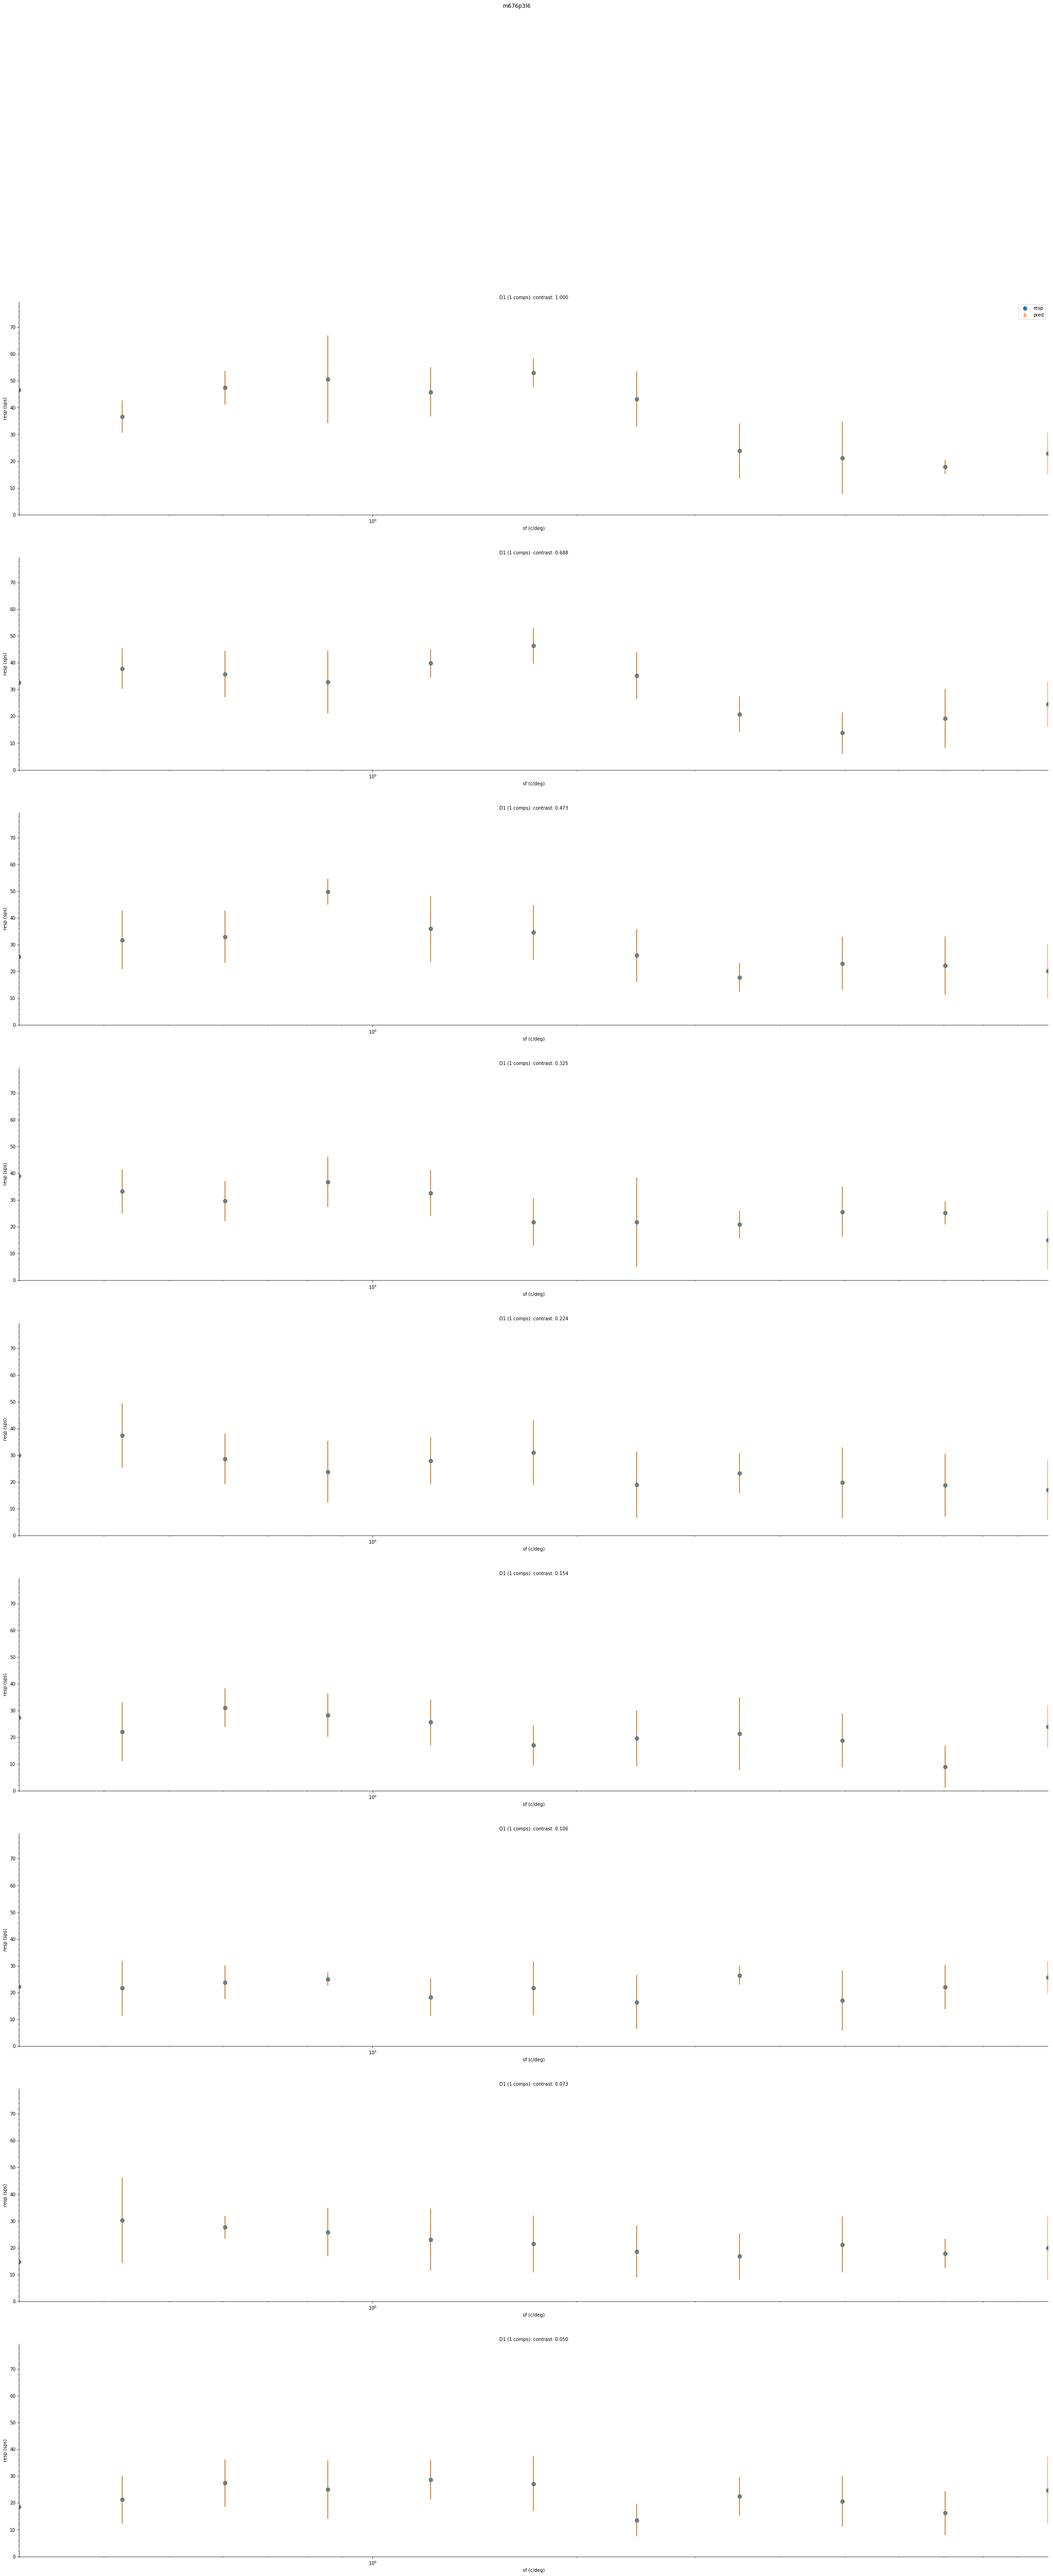

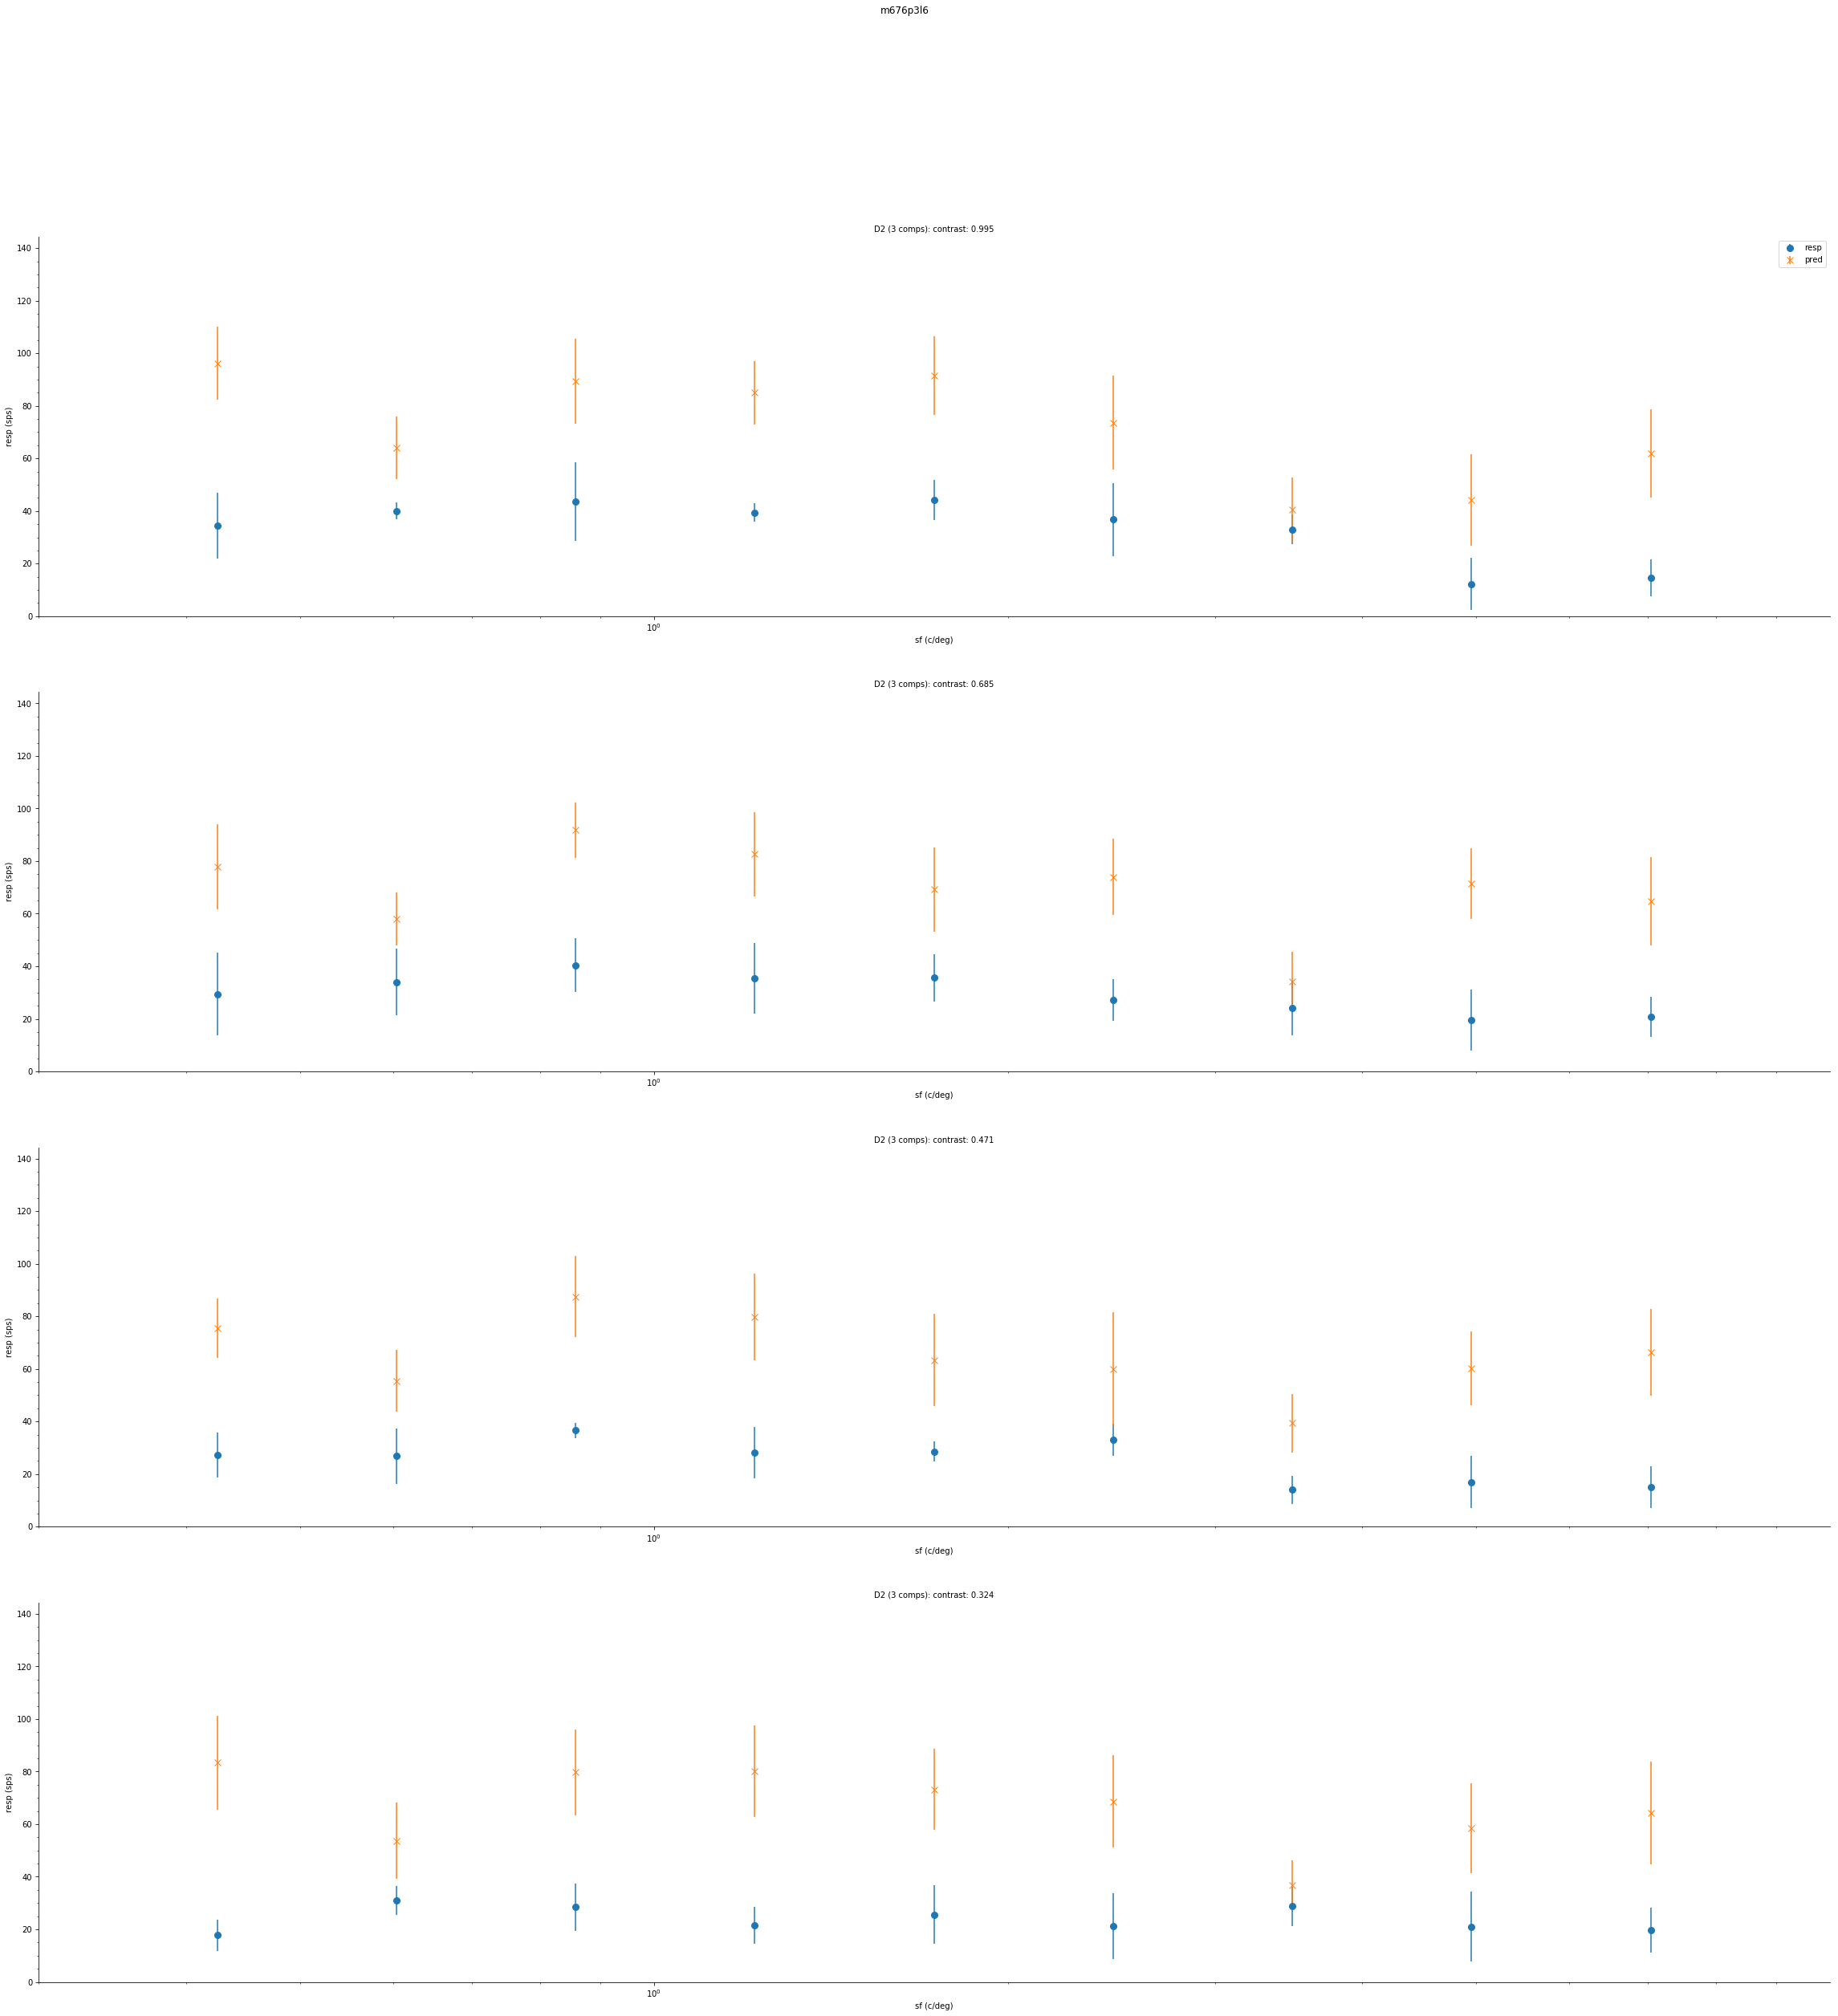

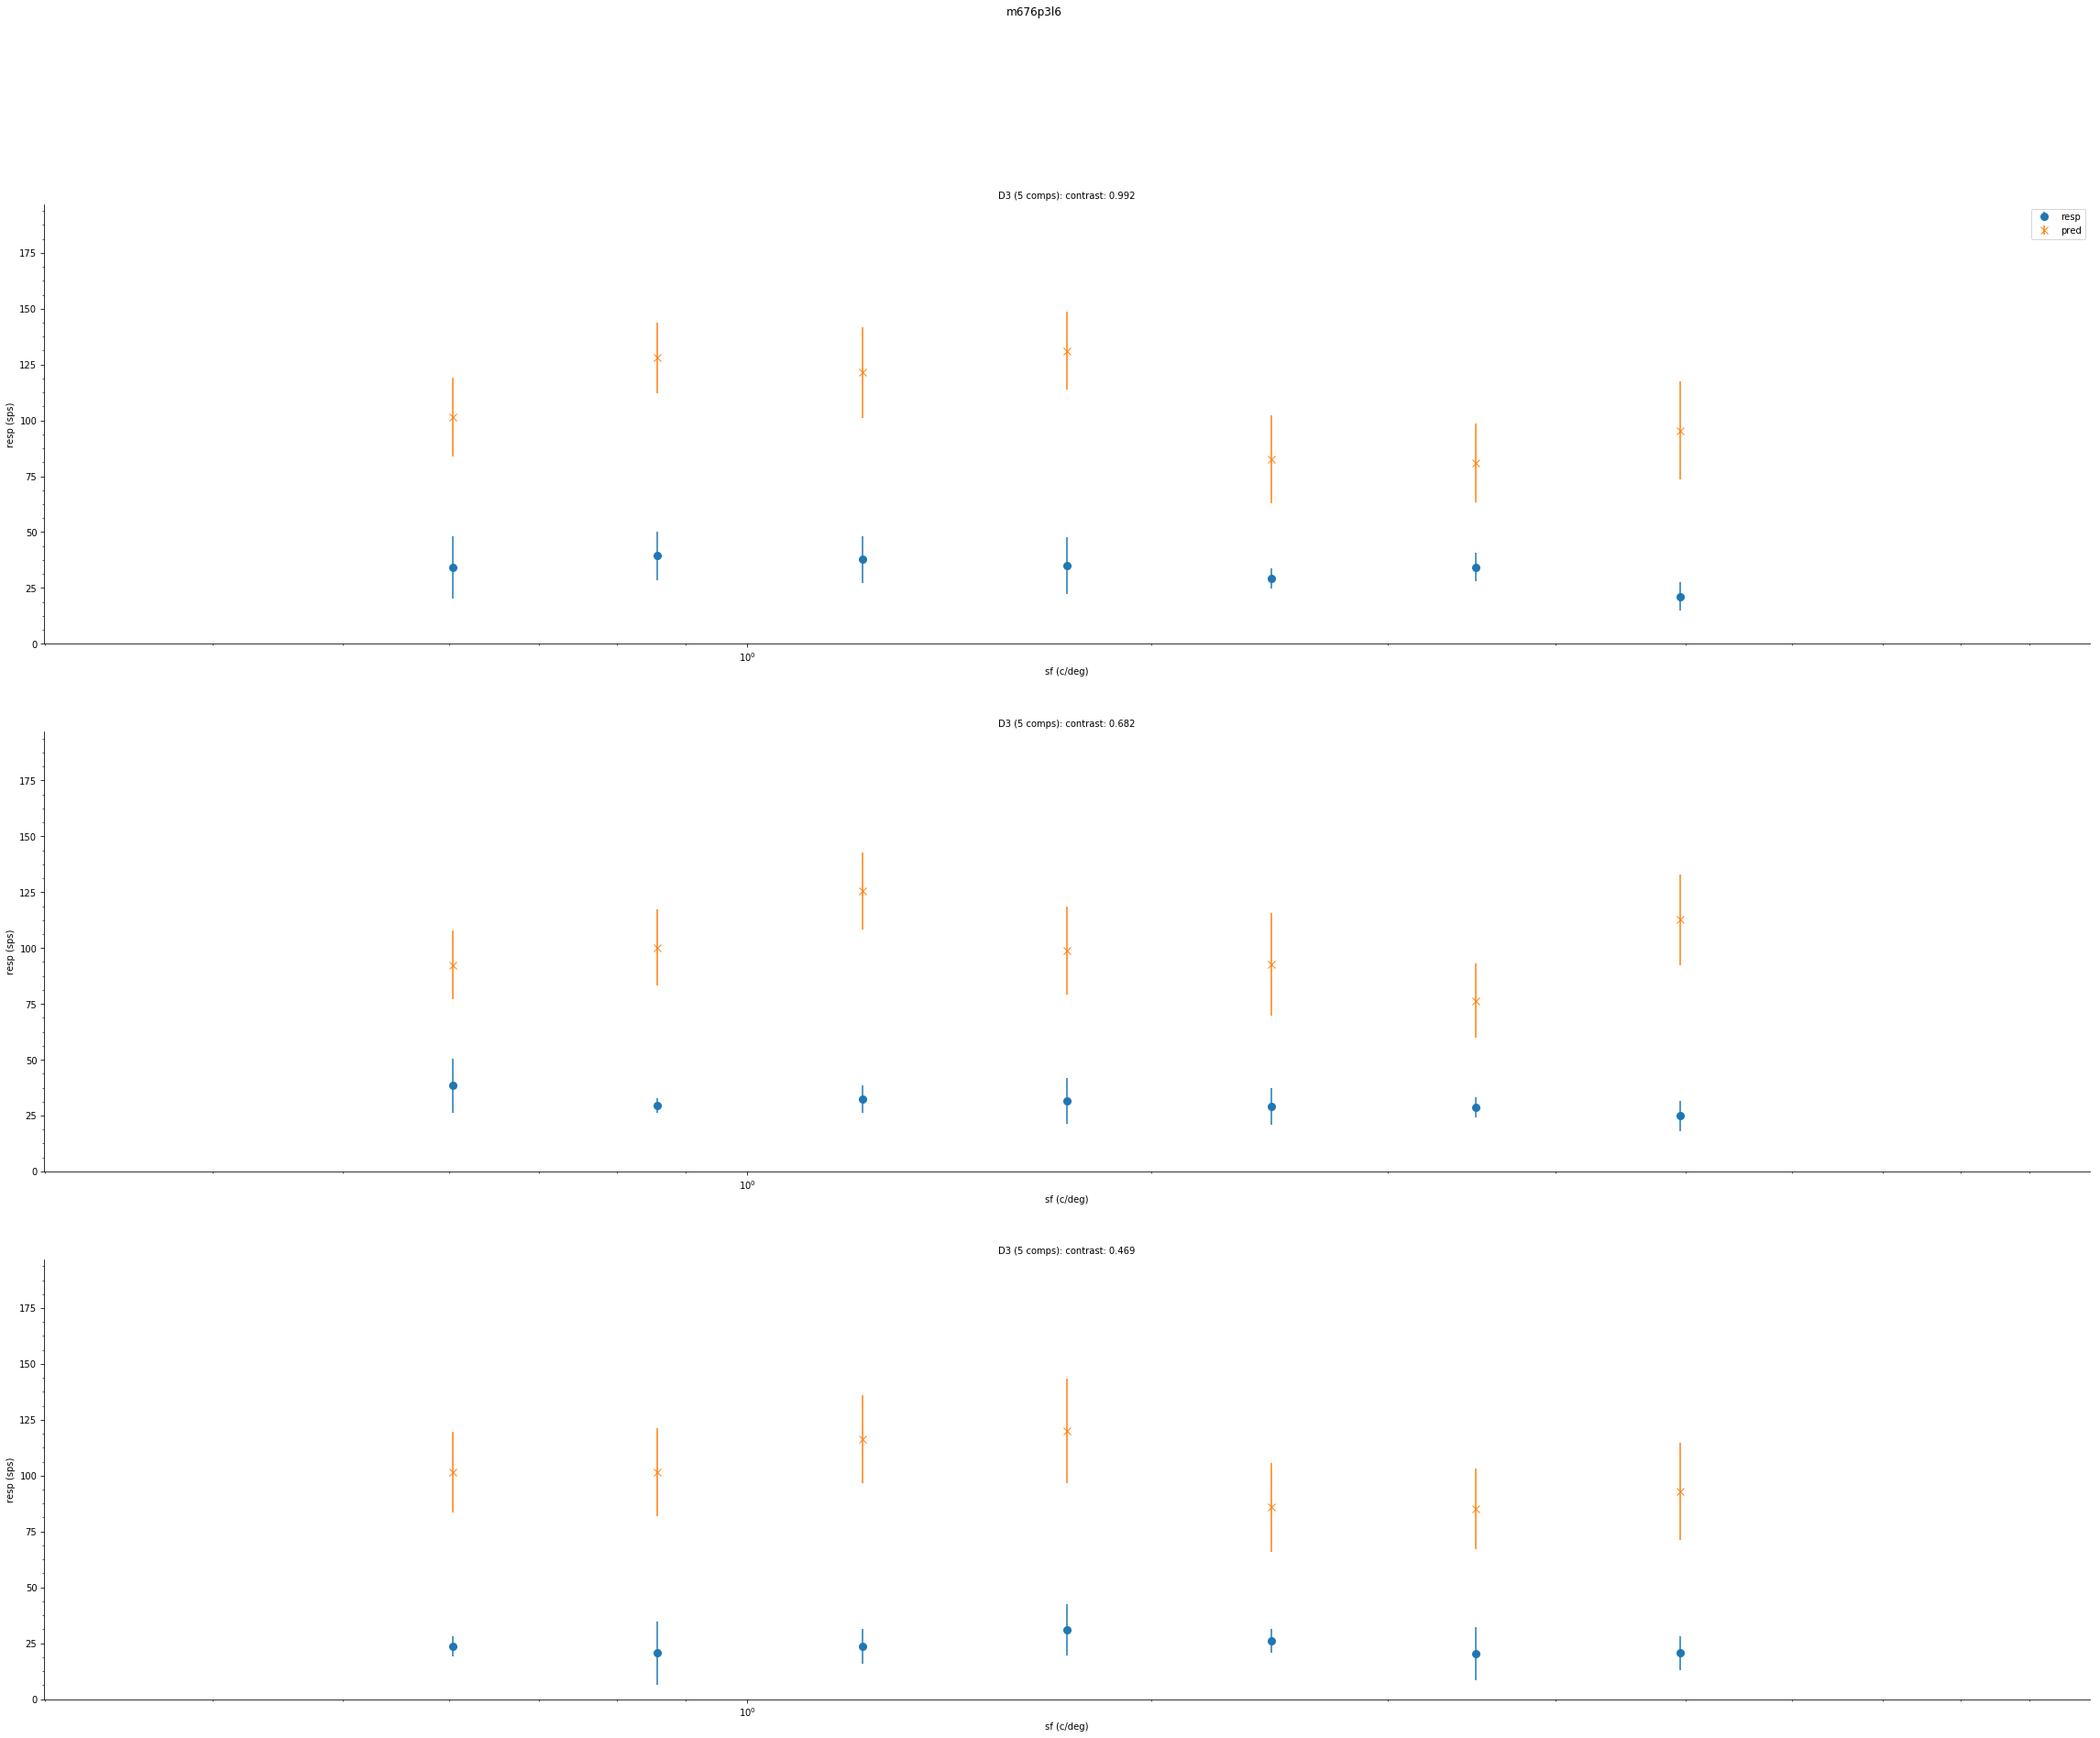

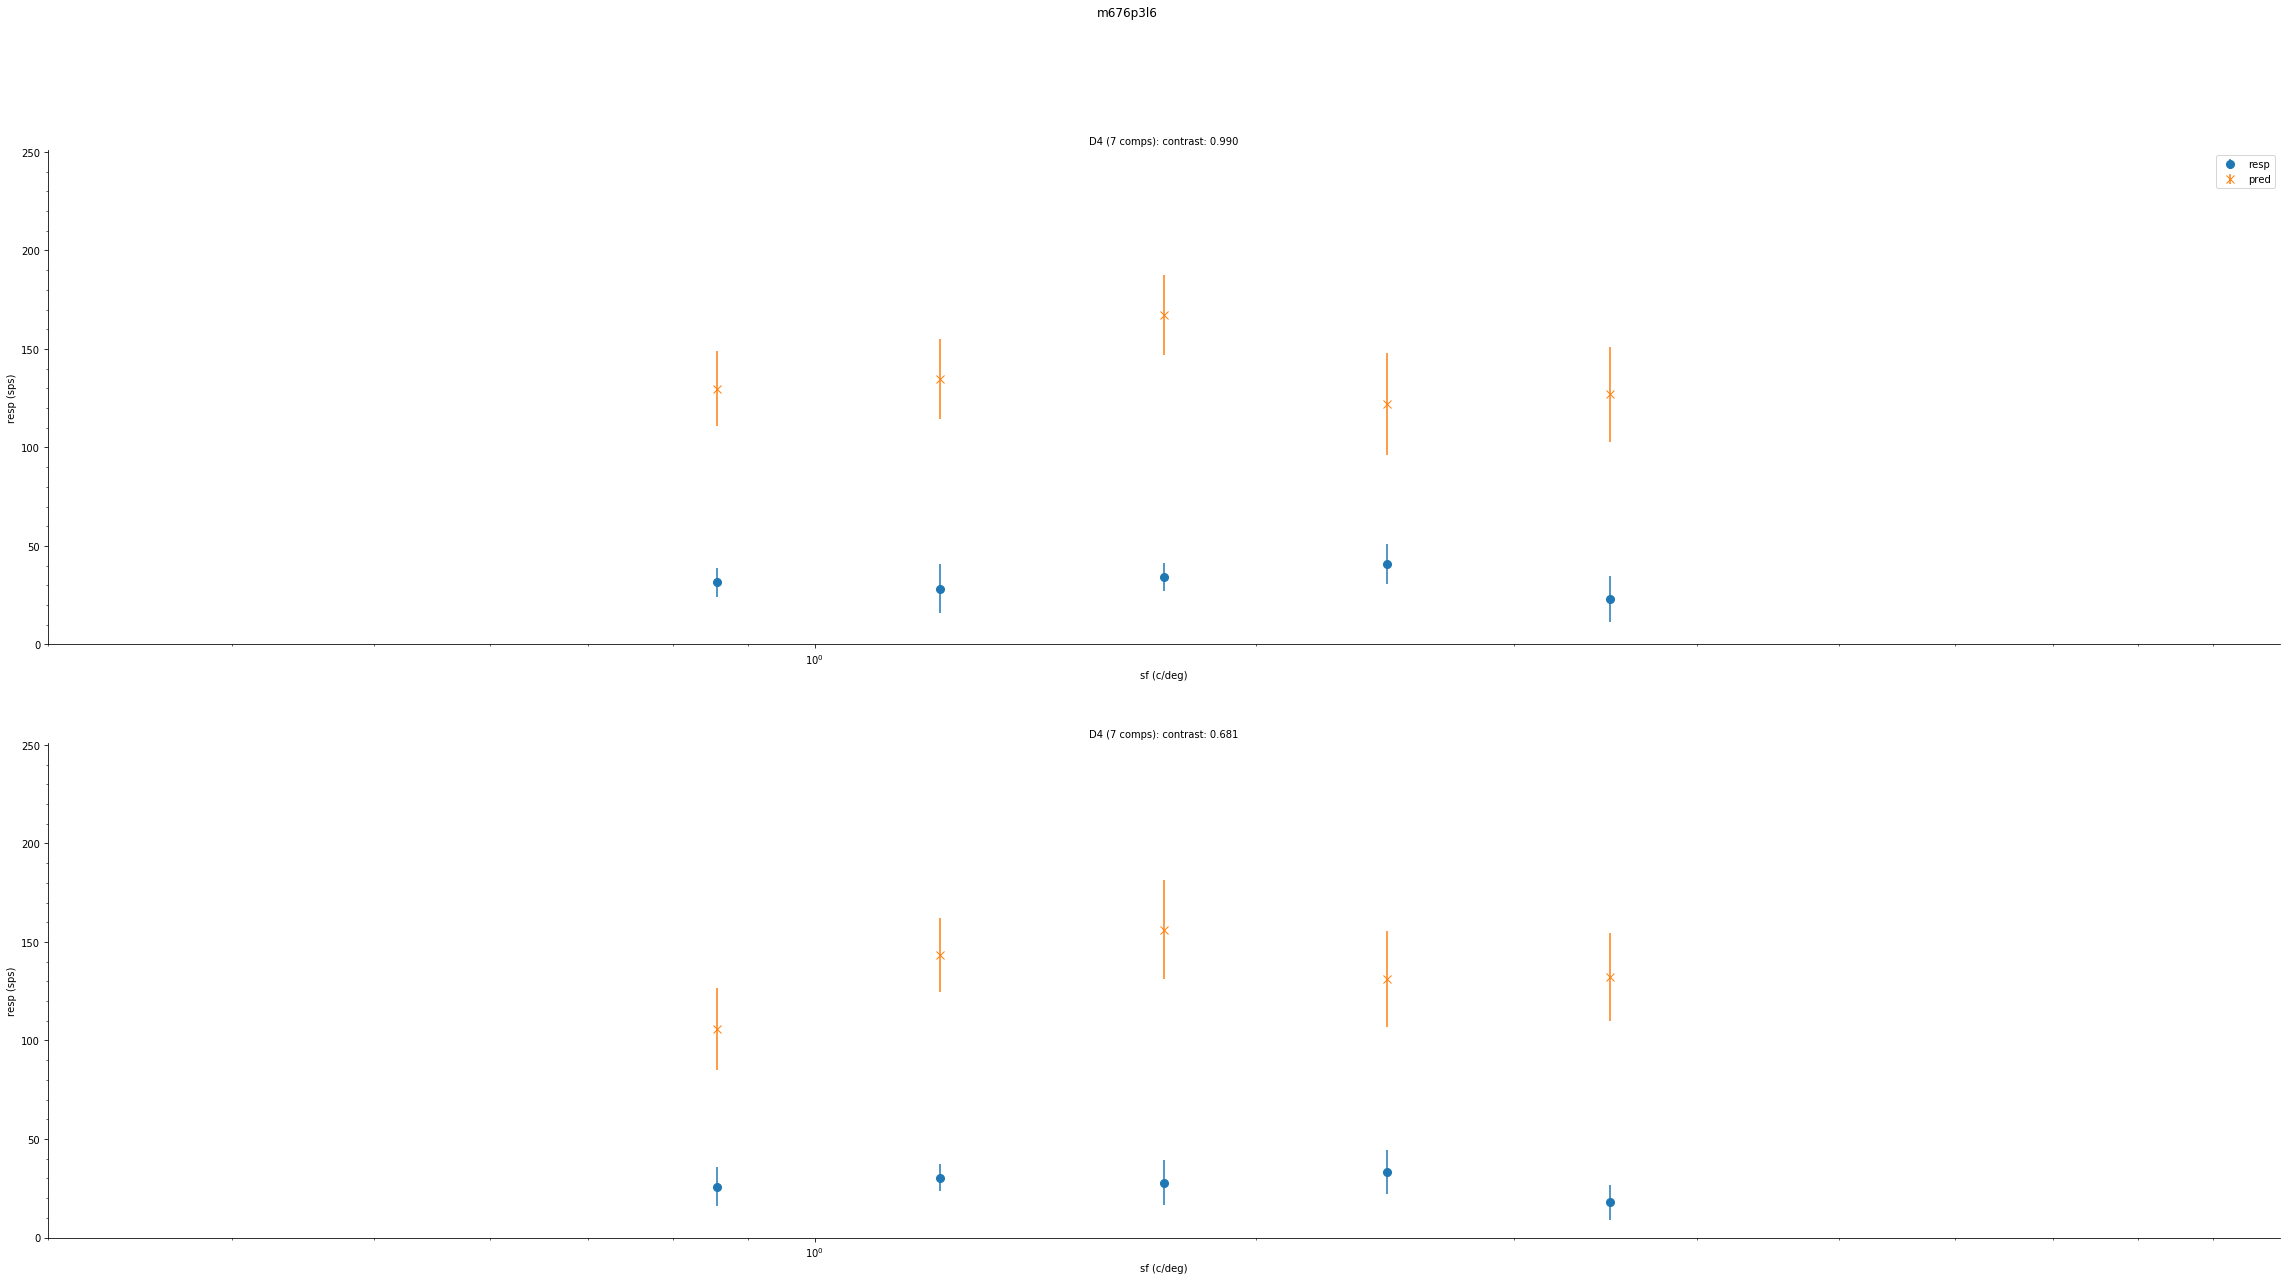

In [11]:
fDisp = []; dispAx = [];

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);    

for d in range(nDisps):
    
    v_cons = val_con_by_disp[d];
    n_v_cons = len(v_cons);
    
    fCurr, dispCurr = plt.subplots(n_v_cons, 1, figsize=(40, n_v_cons*10));
    fDisp.append(fCurr)
    dispAx.append(dispCurr);
    
    maxResp = np.max(np.max(respMean[d, ~np.isnan(respMean[d, :, :])]));
    maxPred = np.max(np.max(predMean[d, ~np.isnan(predMean[d, :, :])]));
    maxResp = np.maximum(maxResp, maxPred)
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = len(v_cons) - c - 1;
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                      respStd[d, v_sfs, v_cons[c]], fmt='o', label='resp');
        # plot linear prediction
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x', label='pred');
        
        # plot descriptive model fit
#         curr_mod_params = descrFits[d, v_cons[c], :];
        #dispAx[d][c_plt_ind].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))
        
        dispAx[d][c_plt_ind].set_xlim((min(all_sfs), max(all_sfs)));
        dispAx[d][c_plt_ind].set_ylim((0, 1.5*maxResp));
        
        dispAx[d][c_plt_ind].set_xscale('log');
#         dispAx[d][c].set_yscale('log');
        dispAx[d][c_plt_ind].set_xlabel('sf (c/deg)'); 
        dispAx[d][c_plt_ind].set_ylabel('resp (sps)');
        dispAx[d][c_plt_ind].set_title('D%d (%d comps): contrast: %.3f' % (d+1, all_disps[d], all_cons[v_cons[c]]));
        if c_plt_ind == 0:
            dispAx[d][c_plt_ind].legend();

    fCurr.suptitle('%s' % dataList['unitName'][which_cell-1])
        
saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'byDisp/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fDisp:
    pdfSv.savefig(f)
pdfSv.close()


#### Plot just sfMix contrasts

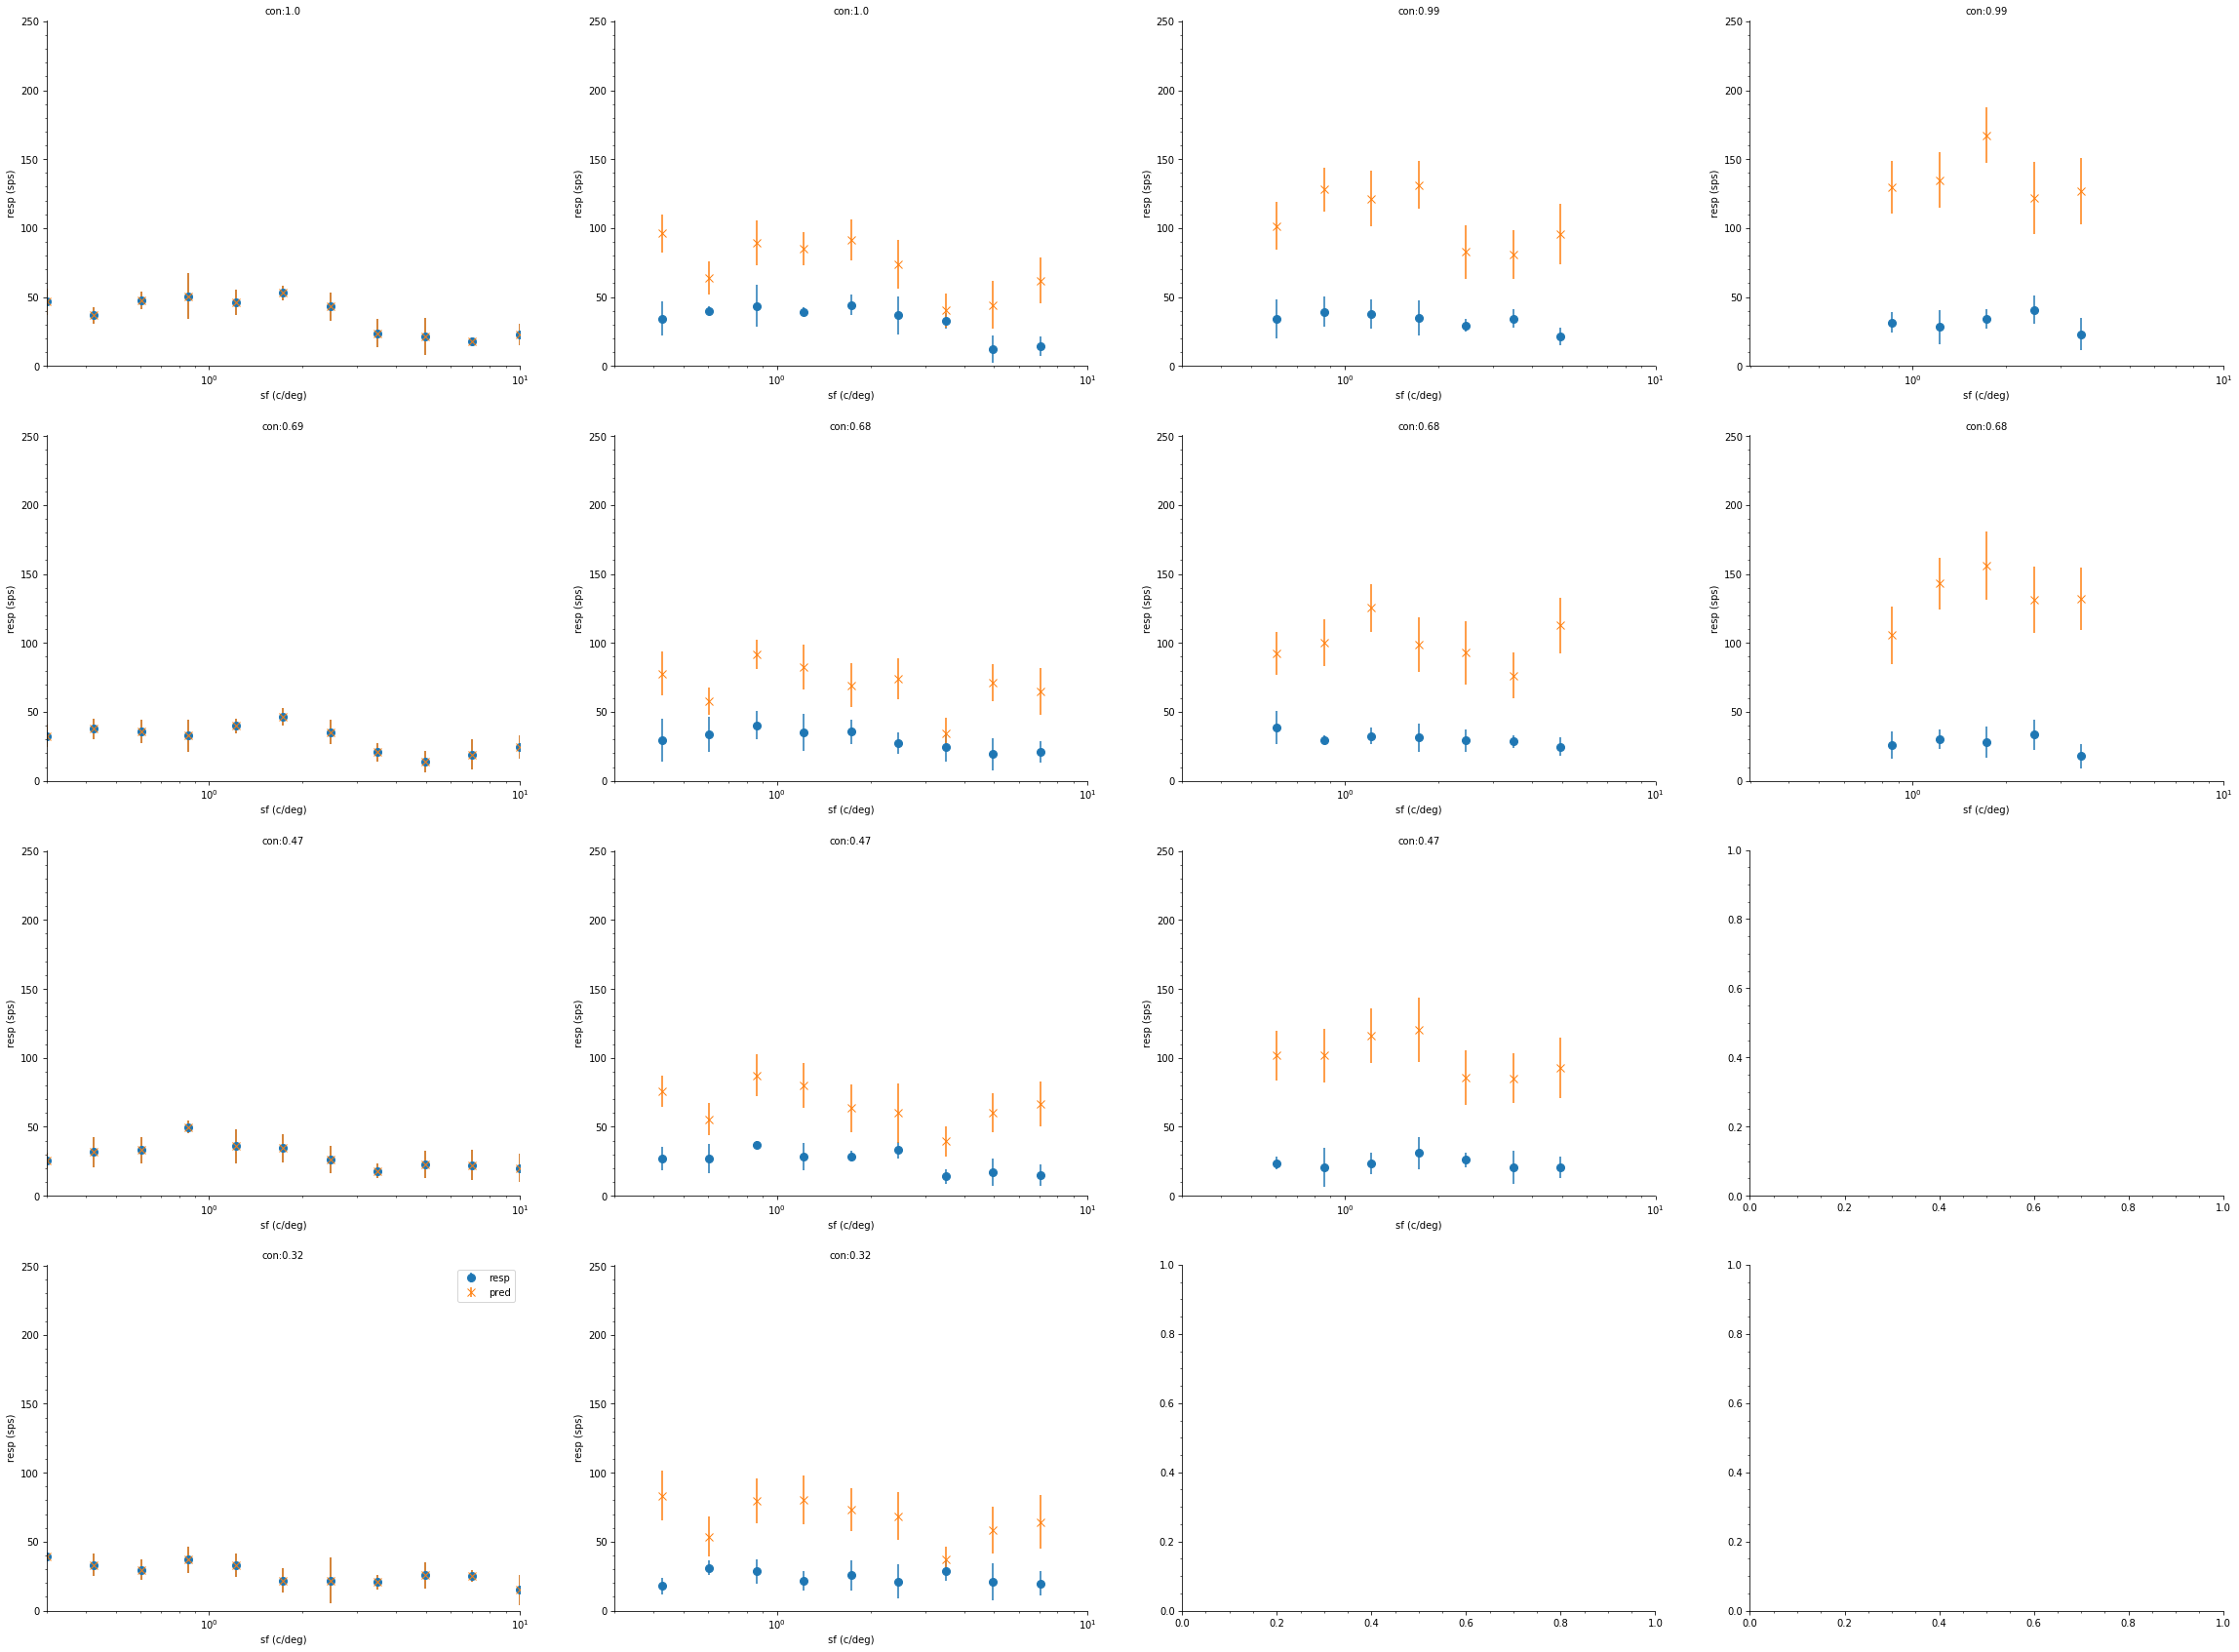

In [12]:
# i.e. highest (up to) 4 contrasts for each dispersion

plot_descr = 0;

mixCons = 4;
maxResp = np.max(np.max(np.max(respMean[~np.isnan(respMean)])));
maxPred = np.max(np.max(np.max(predMean[~np.isnan(predMean)])));
maxResp = np.maximum(maxResp, maxPred)

f, sfMixAx = plt.subplots(mixCons, nDisps, figsize=(40, 30));

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

for d in range(nDisps):
    v_cons = np.array(val_con_by_disp[d]);
    n_v_cons = len(v_cons);
    v_cons = v_cons[np.arange(np.maximum(0, n_v_cons -mixCons), n_v_cons)]; # max(1, .) for when there are fewer contrasts than 4
    n_v_cons = len(v_cons);
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = n_v_cons - c - 1;
        sfMixAx[c_plt_ind, d].set_title('con:' + str(np.round(all_cons[v_cons[c]], 2)))
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                       respStd[d, v_sfs, v_cons[c]], fmt='o', label='resp');

        # plot linear prediction
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x', label='pred');
        
        # plot descriptive model fit
        if plot_descr:
            curr_mod_params = descrFits[d, v_cons[c], :];
        #sfMixAx[c_plt_ind, d].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))

        sfMixAx[c_plt_ind, d].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        sfMixAx[c_plt_ind, d].set_ylim((0, 1.5*maxResp));
        sfMixAx[c_plt_ind, d].set_xscale('log');
        sfMixAx[c_plt_ind, d].set_xlabel('sf (c/deg)');
        sfMixAx[c_plt_ind, d].set_ylabel('resp (sps)');
        
        if d == 0 and c == 0:
            sfMixAx[c_plt_ind, d].legend();
        
saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'sfMixOnly/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Plot contrast response functions

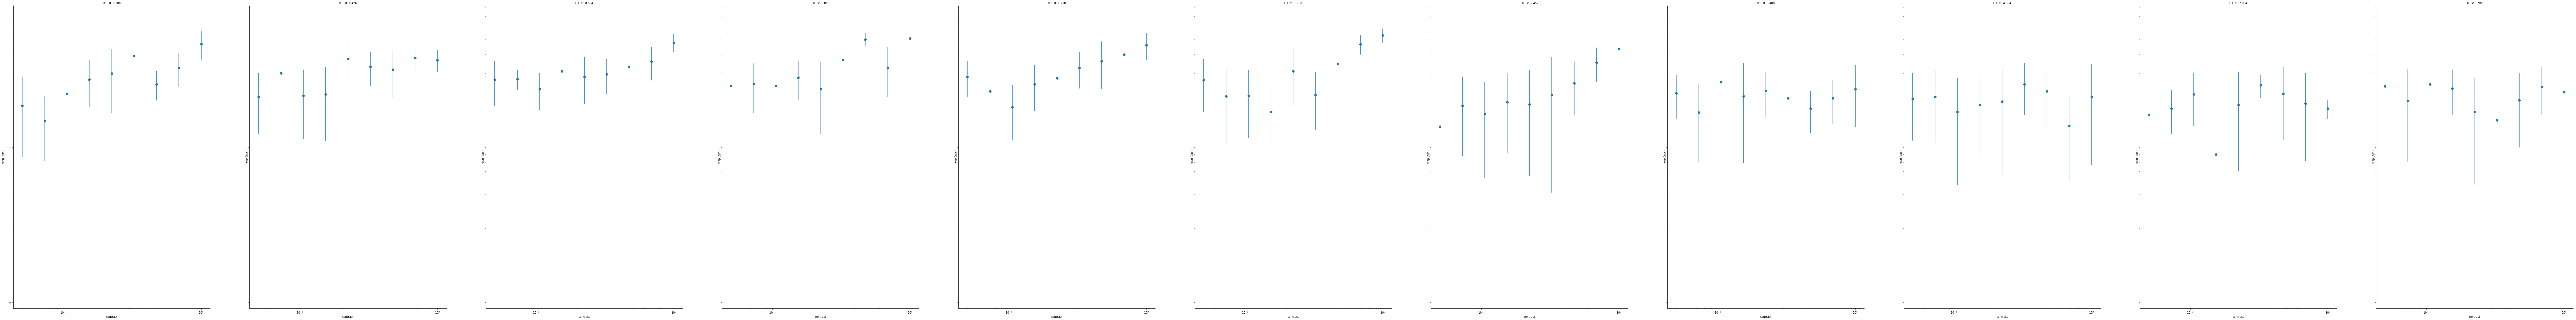

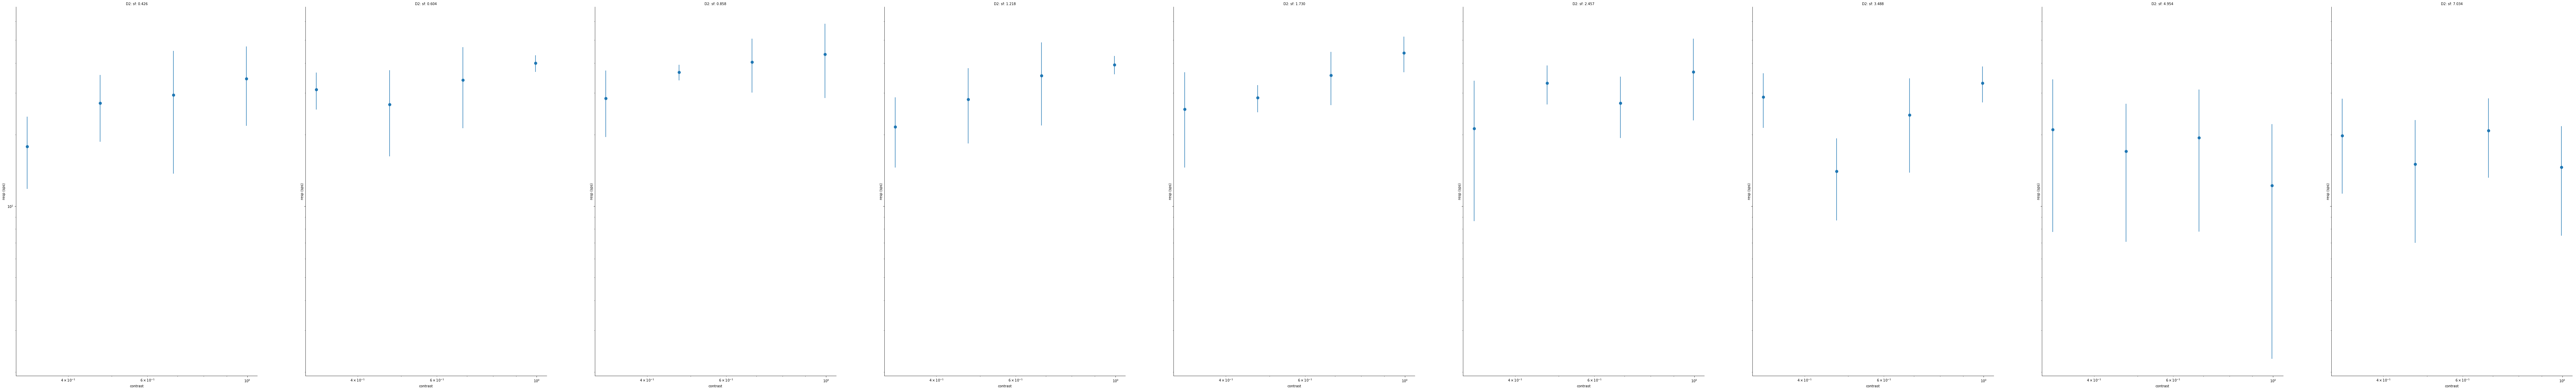

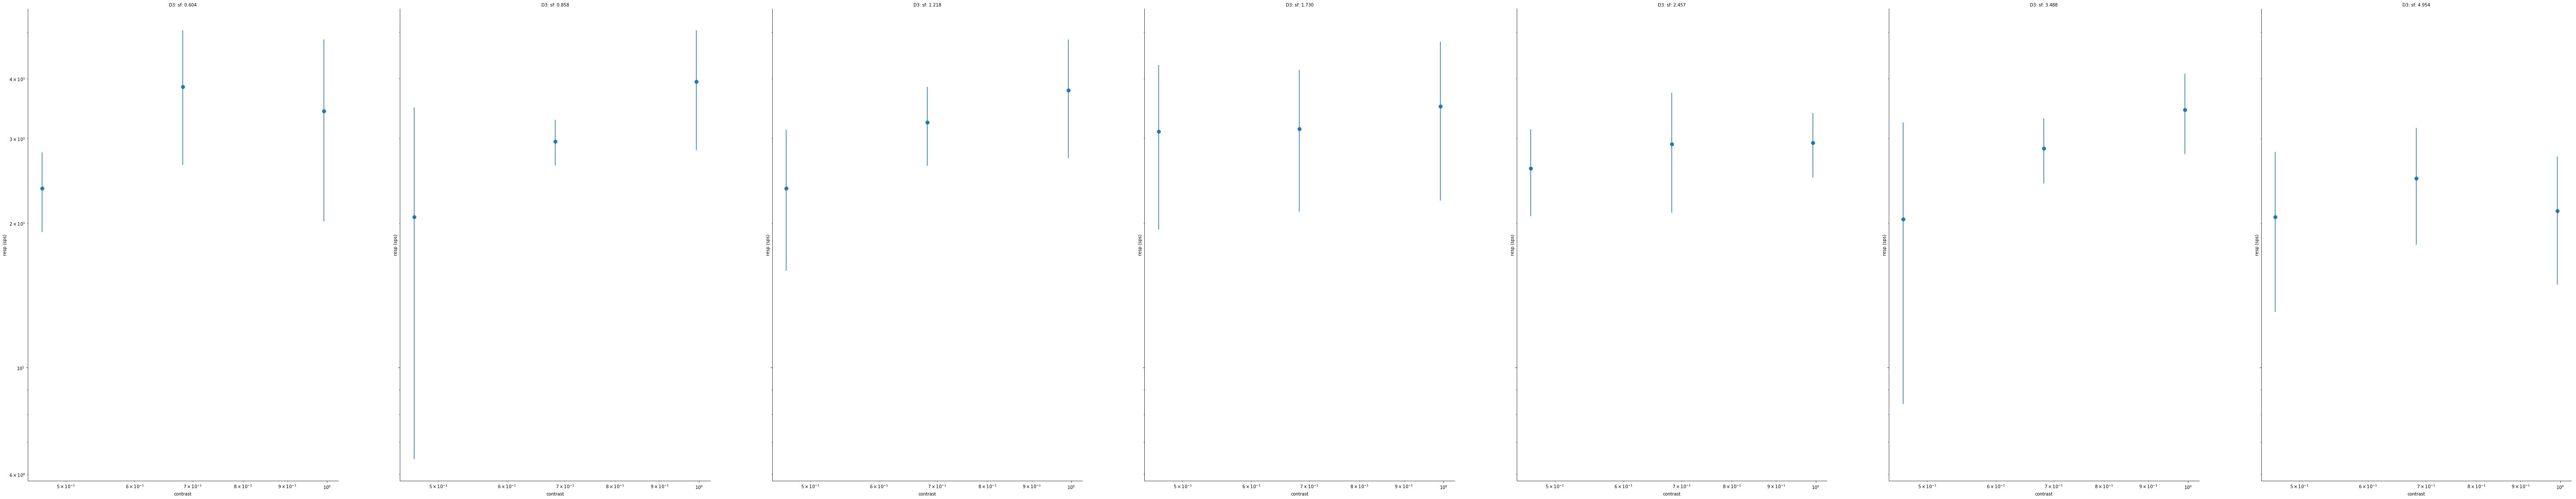

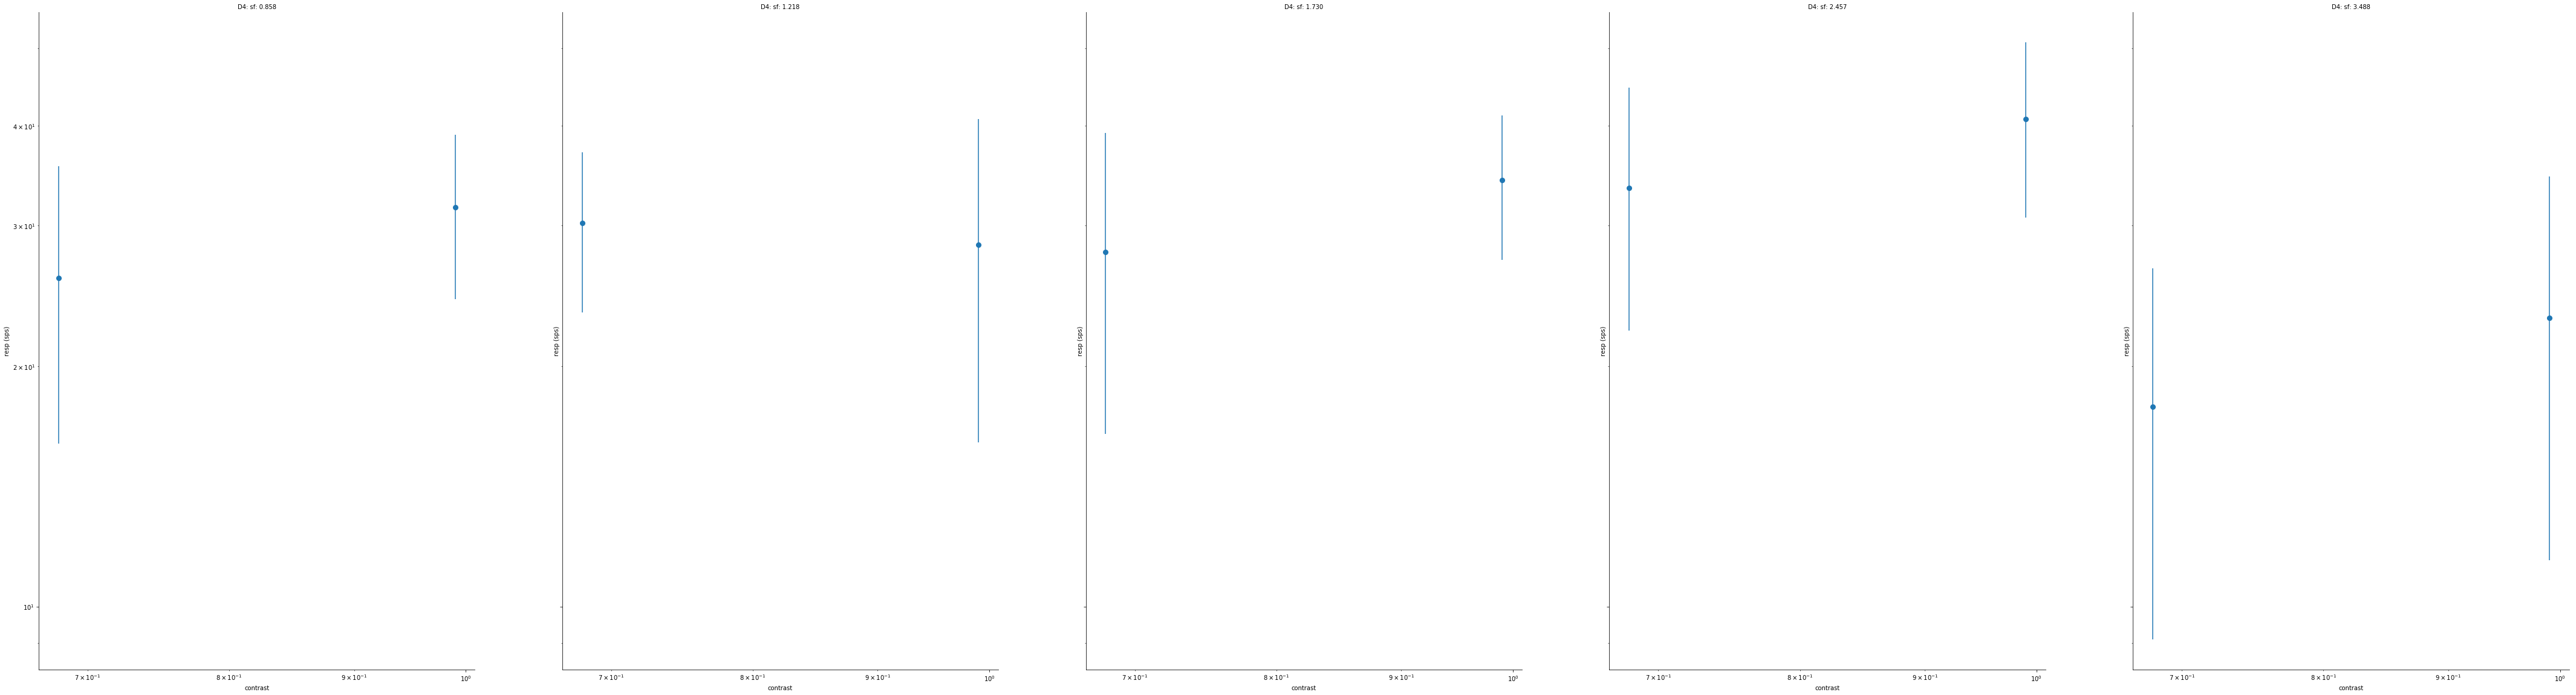

In [13]:
crfAx = []; fCRF = [];

for d in range(nDisps):
    
    # which sfs have at least one contrast presentation?
    v_sfs = np.where(np.sum(~np.isnan(respMean[d, :, :]), axis = 1) > 0);
    n_v_sfs = len(v_sfs[0])
    fCurr, crfCurr = plt.subplots(1, n_v_sfs, figsize=(n_v_sfs*15, 20), sharex = True, sharey = True);
    fCRF.append(fCurr)
    crfAx.append(crfCurr);
    
    for sf in range(n_v_sfs):
        sf_ind = v_sfs[0][sf];
        v_cons = ~np.isnan(respMean[d, sf_ind, :]);
        n_cons = sum(v_cons);
        
        # 0.1 minimum to keep plot axis range OK...should find alternative
        crfAx[d][sf].errorbar(all_cons[v_cons], np.maximum(np.reshape([respMean[d, sf_ind, v_cons]], (n_cons, )), 0.1),
                            np.reshape([respStd[d, sf_ind, v_cons]], (n_cons, )), fmt='o');
        crfAx[d][sf].set_xscale('log');
        crfAx[d][sf].set_yscale('log');
        crfAx[d][sf].set_xlabel('contrast');
        crfAx[d][sf].set_ylabel('resp (sps)');
        crfAx[d][sf].set_title('D%d: sf: %.3f' % (d+1, all_sfs[sf_ind]));

saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'CRF/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fCRF:
    pdfSv.savefig(f)
pdfSv.close()

# BREAK

### Fourier analysis

In [ ]:
autoreload.reload(helper_fcns);

Section for testing out Fourier analysis in python - create a PSTH from the spike times and take the Fourier transform to determine the response amplitude at a given frequency. We will looking specifically for responses at the stimulus temporal frequencies. 

First, find out which trials are valid (i.e. not blanks)

In [ ]:
val_trials = np.where(~np.isnan(data['tf'][0]))[0];

Sort the data in terms of which trials have the largest f1 component

In [ ]:
b = np.argsort(np.abs(data['f1'][val_trials]))

Now which of those indices correspond to dispersed gratings (just so it's easier to check)

In [ ]:
np.where(data['num_comps'][val_trials][b] == 5)[0]

Organize the temporal frequencies for each (valid) trial

In [ ]:
sp = np.array(np.nan * np.zeros(900, ), dtype='O')

In [ ]:
sp[5]

In [ ]:
bbbb.dtype

In [ ]:
bbbb = np.vstack((data['tf'][0], data['tf'][1], data['tf'][2], data['tf'][3], data['tf'][4]));
all_all_tfs = np.transpose(bbbb)[val_trials];
all_tfs = all_all_tfs.astype(int)
atz = [[x[0]] if x[0] == x[1] else x for x in all_tfs];

Now do the analysis: create psth, fourier transform

In [ ]:
binWidth = 1e-3; # in s
whichInd = 890; # which index into "b"
stimDur = 1; # in s

In [ ]:
psth_blank, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes);
spect_blank, _ = helper_fcns.spike_fft(psth_blank);

In [ ]:
psth, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes[val_trials]);
psth_abbr = [x[50:] for x in psth];

In [ ]:
rel_power[b[820]]

In [ ]:
spect, rel_power = helper_fcns.spike_fft(psth, atz);
spect_abbr, rel_power_abbr = helper_fcns.spike_fft(psth_abbr, all_tfs);

In [ ]:
allSpikes = data['spikeTimes'];
valInd = b[whichInd];
trial = val_trials[valInd];

times = np.linspace(0, stimDur, 1+stimDur/binWidth);
c1 = []; c2 = []; c3 = []; c4 = []; c5 = [];

sfs_curr = [x[trial] for x in data['sf']];
cons_curr = [x[trial] for x in data['con']];

tfs_curr = all_tfs[valInd]; # index the below separately, since we've already "killed" invalid trials from this 
psth_curr = psth[valInd];
spect_curr = spect[valInd];
rel_power_curr = rel_power[valInd];

psth_abbr_curr = psth_abbr[valInd]; 
spect_abbr_curr = spect_abbr[valInd];
rp_abbr_curr = rel_power_abbr[valInd];

nyquist = int(len(spectrum)/2);
crop_fft = int(np.minimum(nyquist, 3*np.max(tfsCurr)));

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20, 4))

plt.subplot(1, 3, 1);
plt.plot(times[0:-1], psth_blank);
# plt.plot(times[0:-1], psth_curr);
# plt.plot(times[0:-1], psth);
plt.xlabel('time (s)');
plt.ylabel('spikes (count)')

plt.subplot(1, 3, 2);
plt.stem(np.abs(spect_blank[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_curr[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_abbr_curr[0:crop_fft]), alpha=0.4, color='r');
c1 = plt.axvline(tfs_curr[0], ls='dashed', color='k');
if data['num_comps'][trial] > 1:
    c2 = plt.axvline(tfs_curr[1], ls='dashed', color='r')
    c3 = plt.axvline(tfs_curr[2], ls='dashed', color='g')
    c4 = plt.axvline(tfs_curr[3], ls='dashed', color='b')
    c5 = plt.axvline(tfs_curr[4], ls='dashed', color='c')
    
plt.xlabel('temporal frequency (hz)');
plt.ylabel('power')
if not c2:
    plt.legend([c1], ['stimulus TF'])
else:
    plt.legend((c1, c2, c3, c4, c5), ('tf1', 'tf2', 'tf3', 'tf4', 'tf5'));

plt.subplot(1, 3, 3);
if c2:
    full = plt.plot(np.arange(6), np.insert(rel_power_curr, 0, spect_curr[0]), 'o'); # to plot the DC
#     abbr = plt.plot(np.arange(6), np.insert(rp_abbr_curr, 0, spect_abbr_curr[0]), 'o'); # to plot the DC
    plt.xticks(np.arange(6), ('DC', 'tf1', 'tf2', 'tf3', 'tf4', 'tf5'))
    plt.xlim([-1, 7])
else:
    full = plt.plot(np.arange(2), [spect_curr[0], rel_power_curr[0]], 'o');
#     abbr = plt.plot(np.arange(2), [spect_abbr_curr[0], rp_abbr_curr[0]], 'o');
    plt.xticks(np.arange(2), ('DC', 'f1'))
    plt.xlim([-1, 3])
    
plt.xlabel('Stimulus component');
plt.ylabel('Power');
plt.ylim([-0.1*spect_curr[0], 1.1*spect_curr[0]]);
# plt.legend((full[0], abbr[0]), ('full', 'abbreviated'));

plt.suptitle('%s #%d, tr %d: (sf, con, tf, d) = (%.2f, %.2f, %d, %d)' % (dataList['unitType'][which_cell-1], which_cell, trial+1,
                                                                    sfs_curr[0], np.sum(cons_curr), tfs_curr[0], data['num_comps'][trial]));

## Thinking about phase

After a discussion with Tony, I now know that I have to consider not only the amplitude but the phase of fourier-transformed responses. We can determine the "proper" response phase of a neuron to a particular stimulus and project the component of the response only along this phase. TO see why this is important, imagine there is a baseline f1 response which is entirely noise and therefore occurs at arbitrary phases. The phase of this response will not be linked to the stimulus, and therefore is not stimulus-driven - thus we shouldn't count this is a stimulus-driven activity!

First, plot the (stimulus-blind) responses in 2D space - i.e. amplitude (r) and phase (phi) 

In [ ]:
autoreload.reload(helper_fcns);

In [ ]:
resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

print('dispersion values: ' + str(stimVals[0]))
print('con values: ' + str(np.round(stimVals[1], conDig)))
print('sf values (cpd): ' + str(np.round(stimVals[2], 2)))

print('\n')
for i in range(len(val_con_by_disp)):
    print(('Valid contrast indices for dispersion %d: ' + str(val_con_by_disp[i])) % i)
    
# for i in range()

In [ ]:
### pick which stimulus condition to analyze ###
disp = 0;
con = 11; # index
sf = 4; # index
# how many cycles to fold over? and what bin width in units of one period?
cycle_fold = 2; # fold over N cycles
n_bins = 8; # i.e. split each cycle (or period) into n_bins bins

# constants
binWidth = 1e-3;
stimDur = 1;

In [ ]:
valDisp = validByStimVal[0];
valCon = validByStimVal[1];
valSf = validByStimVal[2];

allDisps = stimVals[0];
allCons = stimVals[1];
allSfs = stimVals[2];

val_trials = np.where(valDisp[disp] & valCon[con] & valSf[sf])

Now, actually compute the response phase relative to the stimulus phase!

In [ ]:
ph_rel_stim, stim_phase, resp_phase, all_tf = helper_fcns.get_true_phase(data, val_trials);

In [ ]:
psth_val, _ = helper_fcns.make_psth(data['spikeTimes'][val_trials], binWidth, stimDur)
_, rel_amp, full_fourier = helper_fcns.spike_fft(psth_val, all_tf)

Now the vector mean

In [ ]:
r, th, _, _ = helper_fcns.polar_vec_mean([rel_amp], [ph_rel_stim]);

Work with the spike times to create rasters (with stimulus cycle plotted) and then align each of the spikes relative to the stimulus cycle start

In [ ]:
f, ax = plt.subplots(3, 2, figsize=(20, 30))

relSpikes = data['spikeTimes'][val_trials];
colors = cm.rainbow(np.linspace(0, 1, len(val_trials[0])))

# spike raster - trial-by-trial
# only works for SINGLE GRATINGS
# draw the beginning of each cycle for each trial
ax = plt.subplot(3, 1, 1)
for i in range(len(relSpikes)):
    ax.scatter(relSpikes[i], i*np.ones_like(relSpikes[i]), s=35, color=colors[i]);
    stimPh = stim_phase[i];
    stimPeriod = np.divide(1, all_tf[i]);
    # i.e. at what point during the trial (in s) does the stimulus component first begin a cycle?
    firstPh0 = helper_fcns.first_ph0(stimPh, all_tf[i])[1];
    for j in range(len(all_tf[i])):
        allPh0 = [stimPeriod[j]*np.arange(-1, all_tf[i][j]) + firstPh0[j]];
        allPh90 = allPh0 + stimPeriod[j]/4;
        allPh180 = allPh90 + stimPeriod[j]/4;
        allPh270 = allPh180 + stimPeriod[j]/4;
    ax.errorbar(allPh0[0], i*np.ones_like(allPh0[0]), 0.25, linestyle='none', color='k')
    ax.errorbar(allPh90[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
    ax.errorbar(allPh180[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
    ax.errorbar(allPh270[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
ax.set_xlabel('time (s)');
ax.set_ylabel('repetition #');
ax.set_title('Spike rasters');

# PSTH - per trial, but folded over N cycles
# only works for SINGLE GRATINGS
ax = plt.subplot(3, 1, 2)
for i in range(len(relSpikes)):
    _, bin_edges, psth_norm = helper_fcns.fold_psth(relSpikes[i], all_tf[i], resp_phase[i], cycle_fold, n_bins);
    plt.plot(bin_edges[0:-1], i-0.5+psth_norm, color=colors[i])
    for i in range(cycle_fold):
        cycStart = plt.axvline(i*stimPeriod[0]);
        cycHalf = plt.axvline((i+0.5)*stimPeriod[0], linestyle='--');
ax.set_xlabel('time (s)');
ax.set_ylabel('spike count (normalized by trial)');
ax.set_title('PSTH folded');
ax.legend((cycStart, cycHalf), ('ph = 0', 'ph = 180'));

# response phase - without accounting for stimulus phase
ax = plt.subplot(3, 2, 5, projection='polar')
ax.scatter(np.radians(resp_phase), rel_amp, s=45, color=colors, clip_on=False);
ax.set_title('Stimulus-blind')
ax.set_ylim(auto='True')
polar_ylim = ax.get_ylim();

# response phase - relative to stimulus phase
ax = plt.subplot(3, 2, 6, projection='polar')
ax.scatter(np.radians(ph_rel_stim), rel_amp, s=45, color=colors, clip_on=False);
ax.plot([0, np.radians(th[0])], [0, r[0]], ls='--', color='k');
ax.set_ylim(polar_ylim);
ax.set_title('Stimulus-accounted');

f.subplots_adjust(wspace=0.2, hspace=0.15);
f.suptitle('Cell %d: disp %d, con %.2f, sf %.2f' % (which_cell, allDisps[disp], allCons[con], allSfs[sf]));

Now save!

In [ ]:
saveName = "/cell_%03d_d%dsf%dcon%d_phase.pdf" % (which_cell, disp, sf, con);
full_save = os.path.dirname(str(save_loc));
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f);
plt.close(f);
pdfSv.close();

### How to add these vectors?

Well, if $v1$ and $v2$ are vectors in polar coordinates (i.e. $v_i = x_i + iy_i)$, then we simply sum the components, i.e. $\Sigma{v_i} = \Sigma{x_i} + i\Sigma{y_i}$. Just perform the usual transformation on the $(r, \theta)$ representation used to create the plots above, and go from there! 

Originally sketched out here, it's now completed in the helper_fcn "polar_vec_mean"

In [ ]:
autoreload.reload(helper_fcns);

Assuming the data file is already loaded, let's start:

In [ ]:
resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

binWidth = 1e-3; # in s
stimDur = 1; # in s

In [ ]:
valDisp = validByStimVal[0];
valCon = validByStimVal[1];
valSf = validByStimVal[2];

allDisps = stimVals[0];
allCons = stimVals[1];
allSfs = stimVals[2];

Let's iterate over all contrasts for a given SF/dispersion combination:

In [ ]:
disp = 0; sf = 0; # as indices
con_inds = val_con_by_disp[disp];

Get the existing fits...

In [ ]:
# simply grab the fits from saved structs
phAdvCurr = phFits[which_cell-1];
rvcCurr = rvcFits[which_cell-1];

# phase
phAdv_model = helper_fcns.get_phAdv_model();
opt_params_phAdv = phAdvCurr['params'][sf];
# rvc
con_values = allCons[con_inds]
rvc_model = helper_fcns.get_rvc_model();
opt_params_rvc = rvcCurr['params'][sf];
adj_resps = rvcCurr['adjMeans'][sf];

In [ ]:
amps = [];
phis = [];
for i in con_inds:
    val_trials = np.where(valDisp[disp] & valCon[i] & valSf[sf])[0];
    
    # get the phase of the response relative to the stimulus (ph_rel_stim)
    ph_rel_stim, st, re, all_tf = helper_fcns.get_true_phase(data, val_trials, dir=-1);
    phis.append(ph_rel_stim);    # get the relevant amplitudes (i.e. the amplitudes at the stimulus TF)
    psth_val, _ = helper_fcns.make_psth(data['spikeTimes'][val_trials])
    _, rel_amp, _ = helper_fcns.spike_fft(psth_val, all_tf)
    amps.append(rel_amp);


In [ ]:
r, th, std_r, std_th = helper_fcns.polar_vec_mean(amps, phis);

In [ ]:
th_center = np.rad2deg(np.radians(-90)+np.radians(th[np.argmax(r)])); # "anchor" to the phase at the highest amplitude response
center_phi = lambda ph1, ph2: np.arcsin(np.sin(np.deg2rad(ph1) - np.deg2rad(ph2)));

In [ ]:
ph_params = opt_params_phAdv;
plot_amps = np.linspace(0, np.max(r), 100);
mod_fit = phAdv_model(ph_params[0], ph_params[1], plot_amps)

In [ ]:
# plt.polar(np.deg2rad(th), r, 'o', alpha=0.5);
# plt.polar(np.deg2rad(mod_fit), plot_amps, '--', alpha=0.5);
plt.polar(np.deg2rad(th-th_center), r, 'o');
# plt.polar(center_phi(mod_fit, th_center), plot_amps, '--');
plt.polar(np.deg2rad(mod_fit-th_center), plot_amps, '--');

### Plotting RVC, phase fits

Reproduce fig 6(a/b) of Movshon, Kiorpes, Hawken, and Cavanaugh (2005) - response amplitude as a function of contrast, and polar plots of response/phase per condition

In [ ]:
autoreload.reload(helper_fcns);

Get the models/fits we need

In [ ]:
# simply grab the fits from saved structs
phAdvCurr = phFits[which_cell-1];
rvcCurr = rvcFits[which_cell-1];

# phase
phAdv_model = helper_fcns.get_phAdv_model();
opt_params_phAdv = phAdvCurr['params'][sf];
# rvc
con_values = allCons[con_inds]
rvc_model = helper_fcns.get_rvc_model();
opt_params_rvc = rvcCurr['params'][sf];
adj_resps = rvcCurr['adjMeans'][sf];

### OLD way - do the caculations here
# phase advance
# phAdv_model, opt_params_phAdv = helper_fcns.phase_advance([r], [th]);
# opt_params_phAdv = opt_params_phAdv[0];
# rvc
# con_values = allCons[con_inds];
# rvc_model, opt_params_rvc = helper_fcns.rvc_fit([r], [con_values]);
# opt_params_rvc = opt_params_rvc[0];

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

n_conds = len(r);
colors = cm.viridis(np.linspace(0, 0.95, n_conds));

# first, response amplitude (with linear contrast) and rvc model fit
plot_cons = np.linspace(0, 1, 100);
mod_fit = rvc_model(opt_params_rvc[0], opt_params_rvc[1], opt_params_rvc[2], plot_cons);

ax = plt.subplot(2, 2, 1);
plt_measured = ax.scatter(allCons[con_inds], adj_resps, color=colors);
# plt_measured = ax.scatter(allCons[con_inds], r, color=colors);
plt_fit = ax.plot(plot_cons, mod_fit, linestyle='--', color='k');
ax.set_xlabel('contrast');
ax.set_ylabel('response (f1)');
ax.set_title('response versus contrast')
ax.legend((plt_measured, plt_fit[0]), ('data', 'model fit'))

# then the plot of phase as a function of ampltude with phase advance model
plot_amps = np.linspace(0, np.max(r), 100);
mod_fit = phAdv_model(opt_params_phAdv[0], opt_params_phAdv[1], plot_amps);

ax = plt.subplot(2, 1, 2);
plt_measured = ax.scatter(r, th, color=colors);
plt_fit = ax.plot(plot_amps, mod_fit, linestyle='--', color='k');
ax.set_xlabel('response amplitude');
ax.set_ylabel('response phase');
ax.set_title('phase advance with amplitude')
ax.legend((plt_measured, plt_fit[0]), ('data', 'model fit'))

# now the polar plot of resp/phase together
ax = plt.subplot(2, 2, 2, projection='polar')
# ax.scatter(np.radians(th), r, color=colors)
ax.scatter(np.radians(th-th[-1]+90), r, color=colors)
ax.plot(np.radians(mod_fit-th[-1]+90), plot_amps, linestyle='--', color='k');
ax.set_ylim(0, 1.25*np.max(r))
ax.set_title('phase advance')

# overall title
f.subplots_adjust(wspace=0.2, hspace=0.25);
f.suptitle('%s #%d: disp %d, sf %.2f cpd' % (dataList['unitType'][which_cell-1], which_cell, allDisps[disp], allSfs[sf]));

# Fit summaries

Here, make some plots to summarize the contrast gain and phase advance metrics

In [107]:
ph_dir = -1; # i.e. positive (right) or negative (left)
if ph_dir == 1:
    fit_suff = 'pos.npy'
if ph_dir == -1:
    fit_suff = 'neg.npy';

In [108]:
rvcFits = np.load(dataPath + 'rvcFits_' + fit_suff, encoding='latin1').item();
phFits = np.load(dataPath + 'phaseAdvanceFits_' + fit_suff, encoding='latin1').item();

In [109]:
allPhAdv = np.array([phFits[i]['phAdv'] for i in phFits])
allConGain = np.array([rvcFits[i]['conGain'] for i in rvcFits])

In [110]:
type_m = np.array([x if dataList['unitType'][x]=='magno' else -1 for x in range(len(dataList['unitType']))], dtype=int)
type_m = type_m[type_m>0]
type_p = np.array([x if dataList['unitType'][x]=='parvo' else -1 for x in range(len(dataList['unitType']))], dtype=int)
type_p = type_p[type_p>0]
type_tbd = np.array([x if dataList['unitType'][x]=='tbd' else -1 for x in range(len(dataList['unitType']))], dtype=int)
type_tbd = type_tbd[type_tbd>0]

#### Split contrast gain, phase advance by cell type

In [111]:
flatten = lambda l: [item for sublist in l for item in sublist]

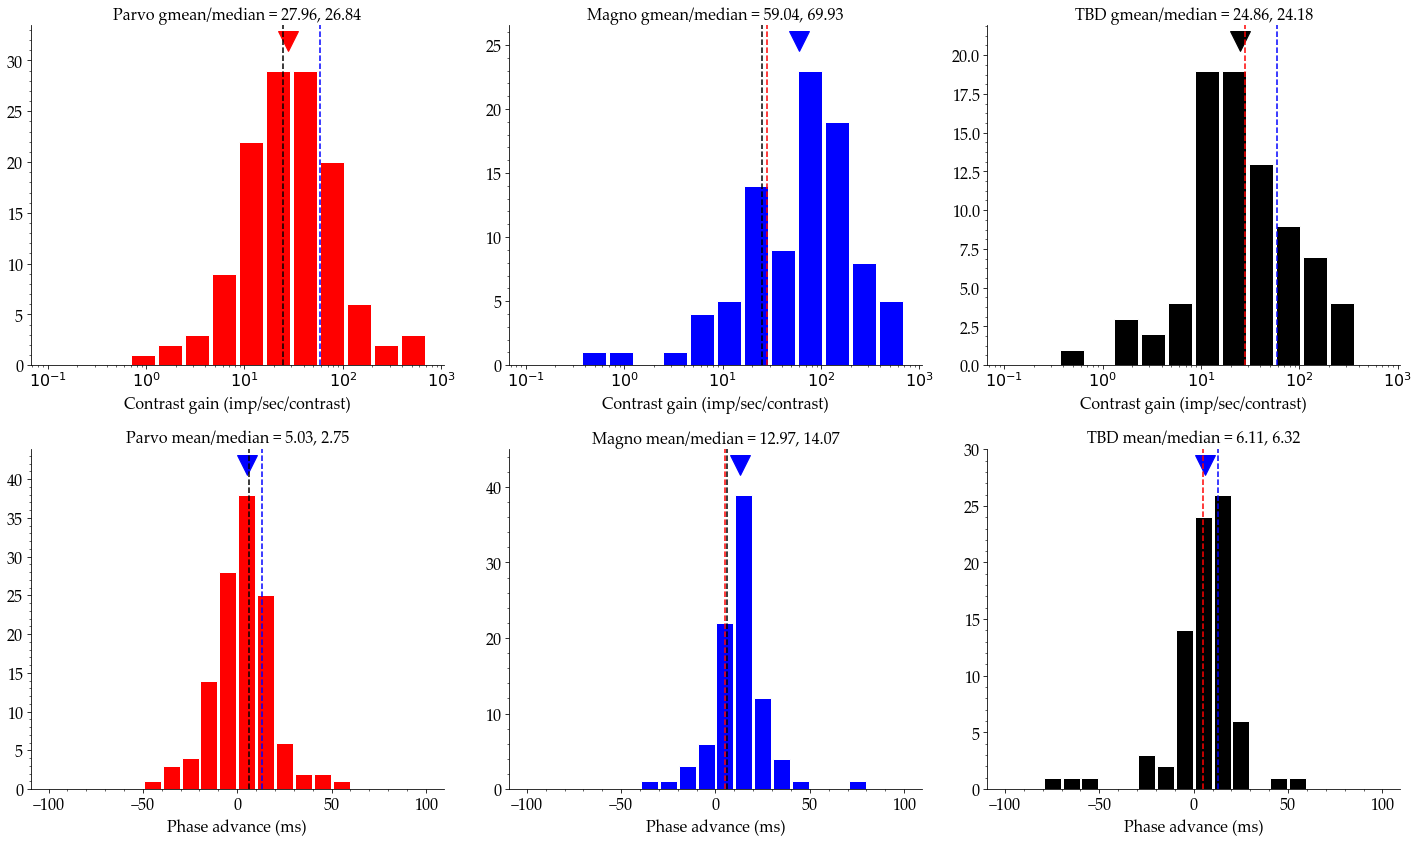

In [112]:
f, ax = plt.subplots(2, 3, figsize=(20, 12))
## CON GAIN
bins = np.geomspace(0.1, 700, 15)
# parvo
plt.subplot(2, 3, 1);
flat_p = flatten(allConGain[type_p])
counts, _, _ = plt.hist(flat_p, bins, color='r', rwidth=0.9)
plt.xscale('log')
[gmean_p, median_p] = [geomean(flat_p), np.median(flat_p)]
plt_gmean = plt.plot(gmean_p, 1.1*np.max(counts), 'v', color='r', markersize=20)
plt.title('Parvo gmean/median = %.2f, %.2f' % (gmean_p, median_p))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# magno
plt.subplot(2, 3, 2);
flat_m = flatten(allConGain[type_m])
counts, _, _ = plt.hist(flat_m, bins, color='b', rwidth=0.9)
plt.xscale('log')
[gmean_m, median_m] = [geomean(flat_m), np.median(flat_m)]
plt_gmean = plt.plot(gmean_m, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Magno gmean/median = %.2f, %.2f' % (gmean_m, median_m))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# tbd
plt.subplot(2, 3, 3);
flat_tbd = flatten(allConGain[type_tbd])
counts, _, _ = plt.hist(flat_tbd, bins, color='k', rwidth=0.9)
plt.xscale('log')
[gmean_t, median_t] = [geomean(flat_tbd), np.median(flat_tbd)]
plt_gmean = plt.plot(gmean_t, 1.1*np.max(counts), 'v', color='k', markersize=20)
plt.title('TBD gmean/median = %.2f, %.2f' % (gmean_t, median_t))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# now put the gmeans of other cell types in each plot
plt.subplot(2, 3, 1); # parvo
plt.axvline(gmean_m, color='b', linestyle='--')
plt.axvline(gmean_t, color='k', linestyle='--')
plt.subplot(2, 3, 2); # magno
plt.axvline(gmean_p, color='r', linestyle='--')
plt.axvline(gmean_t, color='k', linestyle='--')
plt.subplot(2, 3, 3); # tbd
plt.axvline(gmean_p, color='r', linestyle='--')
plt.axvline(gmean_m, color='b', linestyle='--')

## phase advance
bins = np.linspace(-100, 100, 21)
# parvo
plt.subplot(2, 3, 4);
flat_p = flatten(allPhAdv[type_p])
counts, _, _ = plt.hist(flat_p, bins, color='r', rwidth=0.9)
[mean_p, median] = [np.mean(flat_p), np.median(flat_p)]
plt_mean = plt.plot(mean_p, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Parvo mean/median = %.2f, %.2f' % (mean_p, median))
plt.xlabel('Phase advance (ms)')
# magno
plt.subplot(2, 3, 5);
flat_m = flatten(allPhAdv[type_m])
counts, _, _ = plt.hist(flat_m, bins, color='b', rwidth=0.9)
[mean_m, median] = [np.mean(flat_m), np.median(flat_m)]
plt_mean = plt.plot(mean_m, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Magno mean/median = %.2f, %.2f' % (mean_m, median))
plt.xlabel('Phase advance (ms)')
# tbd
plt.subplot(2, 3, 6);
flat_tbd = flatten(allPhAdv[type_tbd])
counts, _, _ = plt.hist(flat_tbd, bins, color='k', rwidth=0.9)
[mean_t, median] = [np.mean(flat_tbd), np.median(flat_tbd)]
plt_mean = plt.plot(mean_t, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('TBD mean/median = %.2f, %.2f' % (mean_t, median))
plt.xlabel('Phase advance (ms)')
# now put the gmeans of other cell types in each plot
plt.subplot(2, 3, 4); # parvo
plt.axvline(mean_m, color='b', linestyle='--')
plt.axvline(mean_t, color='k', linestyle='--')
plt.subplot(2, 3, 5); # magno
plt.axvline(mean_p, color='r', linestyle='--')
plt.axvline(mean_t, color='k', linestyle='--')
plt.subplot(2, 3, 6); # tbd
plt.axvline(mean_p, color='r', linestyle='--')
plt.axvline(mean_m, color='b', linestyle='--')


f.tight_layout()

#### Split contrast gain, phase advance by relative SF

That is, for each cell, get the phase advance/contrast gain for the lowest SF stimulus presented - do the same for all cells and plot; repeat for each relative SF

In [113]:
n_sfs = len(allConGain[0]); # same for all cells...

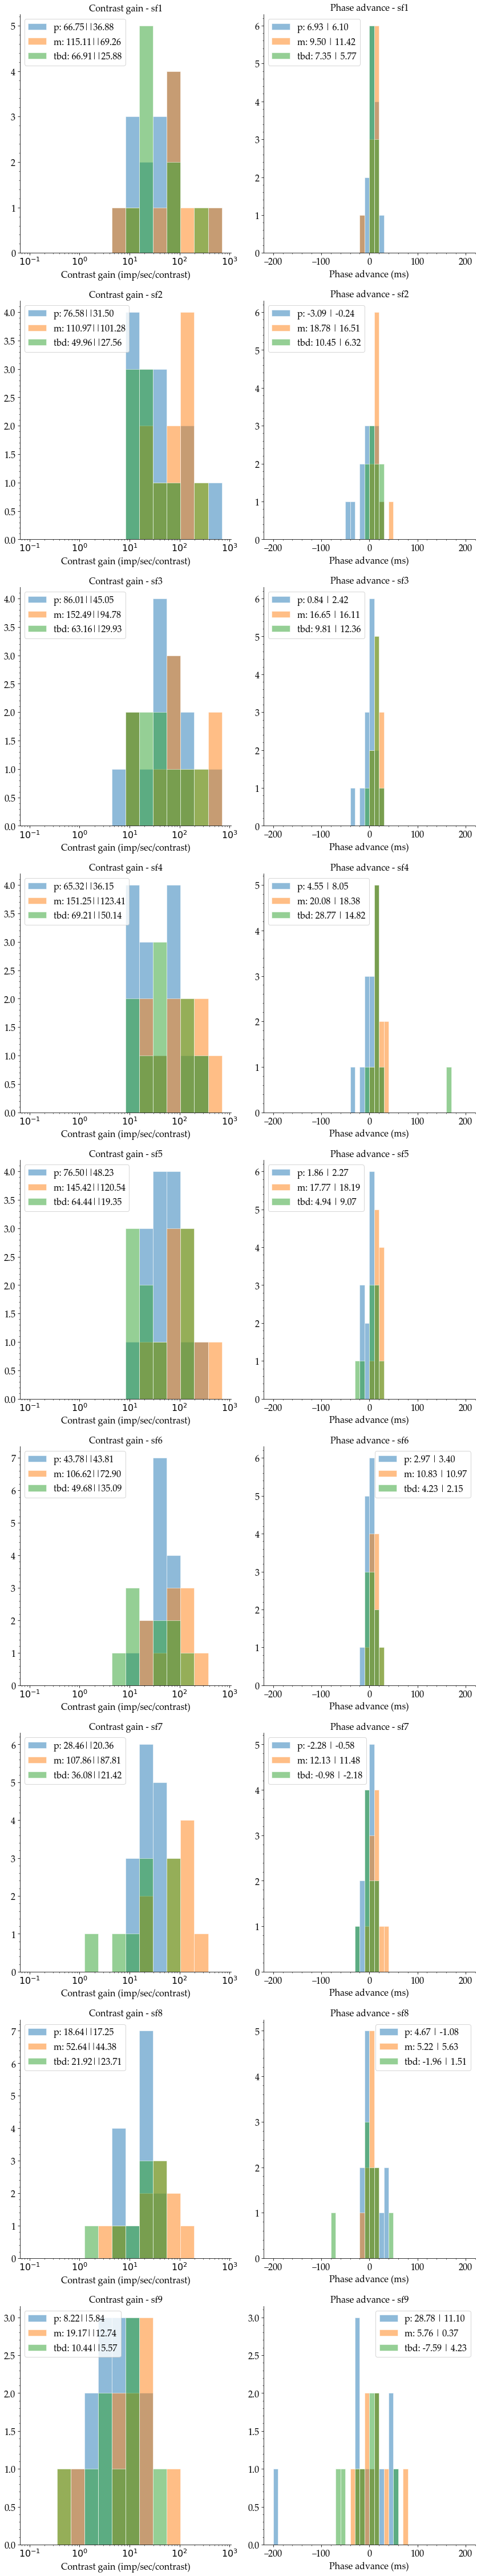

In [114]:
f, ax = plt.subplots(n_sfs, 2, figsize=(12, 7*n_sfs))
# parvo
for sf in range(n_sfs):
    ## CON GAIN
    bins = np.geomspace(0.1, 700, 15)
    plt.subplot(n_sfs, 2, 2*sf + 1);
    # parvo
    flat_p = [allConGain[x][sf] for x in type_p]
    [mean, median] = [np.mean(flat_p), np.median(flat_p)]
    plt.hist(flat_p, bins, alpha=0.5, label = 'p: %.2f||%.2f' % (mean, median))
    plt.xscale('log')
    # magno
    flat_m = [allConGain[x][sf] for x in type_m]
    [mean, median] = [np.mean(flat_m), np.median(flat_m)]
    plt.hist(flat_m, bins, alpha=0.5, label = 'm: %.2f||%.2f' % (mean, median))
    plt.xscale('log')
    # tbd
    flat_tbd = [allConGain[x][sf] for x in type_tbd]
    [mean, median] = [np.mean(flat_tbd), np.median(flat_tbd)]
    plt.hist(flat_tbd, bins, alpha=0.5, label = 'tbd: %.2f||%.2f' % (mean, median))
    plt.title('Contrast gain - sf%d' % (sf+1))
    plt.xlabel('Contrast gain (imp/sec/contrast)')
    plt.xscale('log')
    plt.legend();
    ## PHASE ADVANCE
    bins = np.linspace(-200, 200, 41)
    plt.subplot(n_sfs, 2, 2*sf + 2);
    # parvo
    flat_p = [allPhAdv[x][sf] for x in type_p]
    [mean, median] = [np.mean(flat_p), np.median(flat_p)]
    p_plt = plt.hist(flat_p, bins, alpha=0.5, label = 'p: %.2f | %.2f' % (mean, median))
    # magno
    flat_m = [allPhAdv[x][sf] for x in type_m]
    [mean, median] = [np.mean(flat_m), np.median(flat_m)]
    m_plt = plt.hist(flat_m, bins, alpha=0.5, label = 'm: %.2f | %.2f' % (mean, median))
    # tbd
    flat_tbd = [allPhAdv[x][sf] for x in type_tbd]
    [mean, median] = [np.mean(flat_tbd), np.median(flat_tbd)]
    t_plt = plt.hist(flat_tbd, bins, alpha=0.5, label = 'tbd: %.2f | %.2f' % (mean, median))
    plt.title('Phase advance - sf%d' % (sf+1))
    plt.xlabel('Phase advance (ms)')
    plt.legend();

f.tight_layout()

# Checking contrast gain, phase advance

Comparing my values of contrast gain and phase advance to those from the Movshon/Kiorpes '05 paper, my contrast gains and phase advance values are low. This could simply be a result of poorly calculating the values.

### Phase advance

In their '05 paper, the parvo/magno phase advance means are ~20/60 ms, respectively in adults. Mine are much lower in the above plots, but the form of the distributions are similar, which suggest a numerical (i.e. quantitative and not qualitative) error.

Their equation for phase advance (in milliseconds) is $\tau = p/C_{max}/\omega_t$, where $p :=$ slope of phase (per unit response amplitude), $C_{max} :=$ the maximum test contrast used to fit the phase-amplitude relationship, $p$, and $\omega_t :=$ the stimulus period. 

Working backwards, let's think about units. The phase-amplitude model is $\phi(C) = \phi_0 + p*A(C)$, where $\phi$ are units of degrees. Thus, if $[A(C)] = spks/s$, then $[p] = deg/(spks/s)$. 

But for $[\tau]= (m)s$ and $[\omega_t] = s/cycles$; $[C_{max}] = unitless$, then $[p] = s^2/cycle$ ???

This is perhaps a more obtuse way of reasoning. Instead, let's think about what phase advance _means_. Suppose over a specified range, the response phase advances by 50 degrees, i.e. $50/360$ of a cycle. If each cycle takes one second, then the phase has advanced by $50/360$ seconds. If each cycle takes $1/2$ second (i.e. a temporal frequency of 2 Hz), then the phase has advanced by $(50/360)/2$ seconds. Thus, a general rule is $cycleFrac/tf$ seconds.

Cycle fraction ($cf$; over the range of response amplitudes) can be computed as $cf = p*maxResp$, with $[cf] = [cycle]$. Unit-wise, then, $[\phi_{adv}] = [cf] / [tf] = [cycle]/[cycle/s] = [s]$

This is what I've implemented thus far, but the values are still wrong. But, a key portion of the calculation is dependent on the value of the maximum response. If that value is also incorrect, then so will the phase advance calculation. If I fix contrast gain (by checking the FFT calculation for amplitude preservation), then perhaps phase advance will fix itself.

### Contrast gain

A wrinkle in my plan to solve both problems by fixing the amplitude/f1 problem is that my current calulcation of F1 values agrees with those calculated in Expo. So either Expo incorrectly calculates F1 (unlikely) or something else is happening.

Perhaps if we plot _just_ the best contrast gain from each cell, the values will be more in line with those from the '05 paper. Let's try...

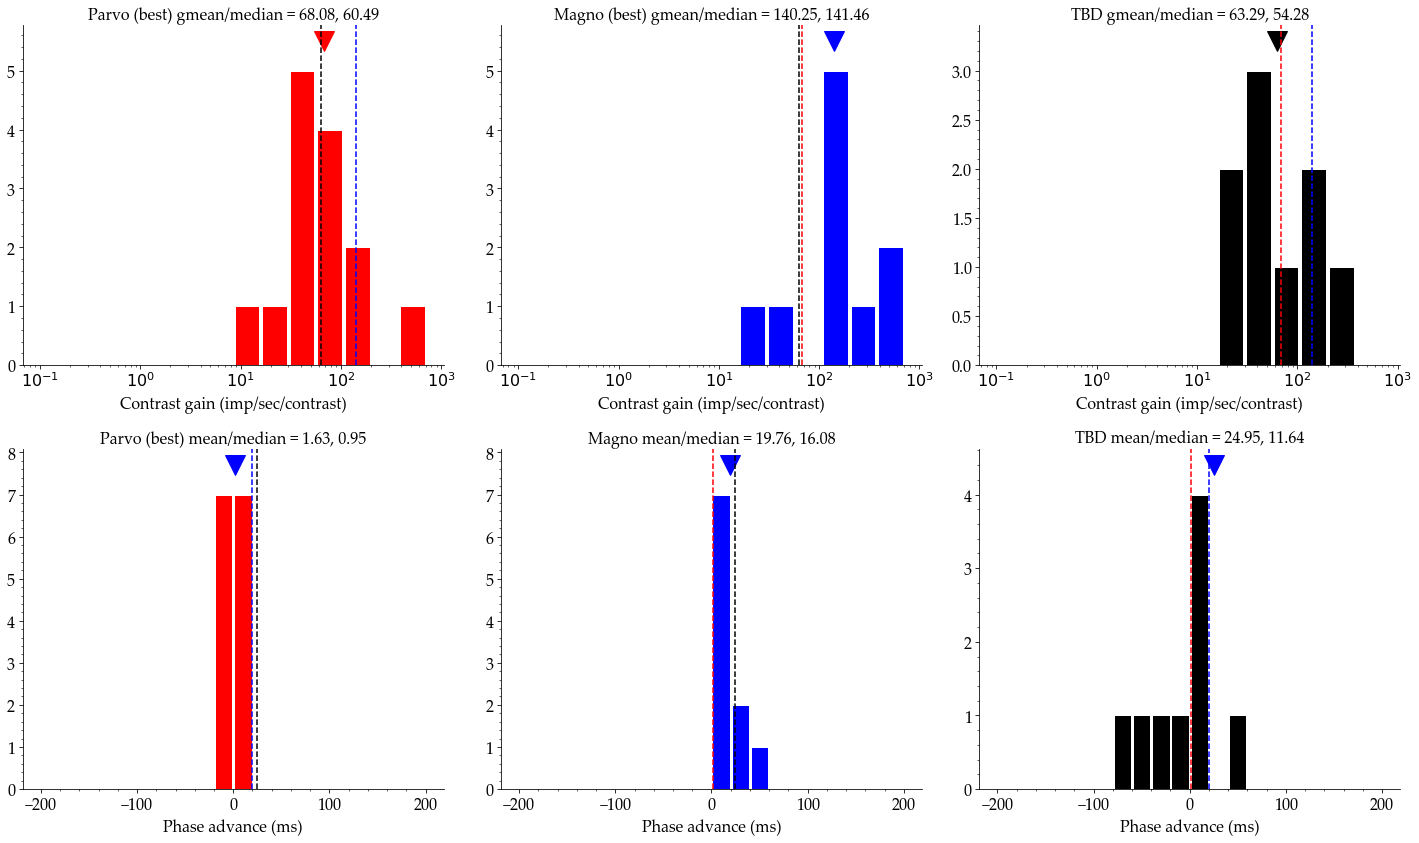

In [117]:
f, ax = plt.subplots(2, 3, figsize=(20, 12))
## CON GAIN
bins = np.geomspace(0.1, 700, 15)
# parvo
plt.subplot(2, 3, 1);
best_p = [np.max(x) for x in allConGain[type_p]]
counts, _, _ = plt.hist(best_p, bins, color='r', rwidth=0.9)
plt.xscale('log')
[gmean_p, median_p] = [geomean(best_p), np.median(best_p)]
plt_gmean = plt.plot(gmean_p, 1.1*np.max(counts), 'v', color='r', markersize=20)
plt.title('Parvo (best) gmean/median = %.2f, %.2f' % (gmean_p, median_p))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# magno
plt.subplot(2, 3, 2);
best_m = [np.max(x) for x in allConGain[type_m]]
counts, _, _ = plt.hist(best_m, bins, color='b', rwidth=0.9)
plt.xscale('log')
[gmean_m, median_m] = [geomean(best_m), np.median(best_m)]
plt_gmean = plt.plot(gmean_m, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Magno (best) gmean/median = %.2f, %.2f' % (gmean_m, median_m))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# tbd
plt.subplot(2, 3, 3);
best_tbd = [np.max(x) for x in allConGain[type_tbd]]
counts, _, _ = plt.hist(best_tbd, bins, color='k', rwidth=0.9)
plt.xscale('log')
[gmean_t, median_t] = [geomean(best_tbd), np.median(best_tbd)]
plt_gmean = plt.plot(gmean_t, 1.1*np.max(counts), 'v', color='k', markersize=20)
plt.title('TBD gmean/median = %.2f, %.2f' % (gmean_t, median_t))
plt.xlabel('Contrast gain (imp/sec/contrast)')
# now put the gmeans of other cell types in each plot
plt.subplot(2, 3, 1); # parvo
plt.axvline(gmean_m, color='b', linestyle='--')
plt.axvline(gmean_t, color='k', linestyle='--')
plt.subplot(2, 3, 2); # magno
plt.axvline(gmean_p, color='r', linestyle='--')
plt.axvline(gmean_t, color='k', linestyle='--')
plt.subplot(2, 3, 3); # tbd
plt.axvline(gmean_p, color='r', linestyle='--')
plt.axvline(gmean_m, color='b', linestyle='--')

## phase advance
bins = np.linspace(-200, 200, 21)
# parvo
plt.subplot(2, 3, 4);
inds = [np.argmax(x) for x in allConGain[type_p]] # get the (sf) index which corresponds to the highest con. gain
best_p = [allPhAdv[type_p[x]][inds[x]] for x in range(len(inds))]
counts, _, _ = plt.hist(best_p, bins, color='r', rwidth=0.9)
[mean_p, median] = [np.mean(best_p), np.median(best_p)]
plt_mean = plt.plot(mean_p, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Parvo (best) mean/median = %.2f, %.2f' % (mean_p, median))
plt.xlabel('Phase advance (ms)')
# magno
plt.subplot(2, 3, 5);
inds = [np.argmax(x) for x in allConGain[type_m]] # get the (sf) index which corresponds to the highest con. gain
best_m = [allPhAdv[type_m[x]][inds[x]] for x in range(len(inds))]
counts, _, _ = plt.hist(best_m, bins, color='b', rwidth=0.9)
[mean_m, median] = [np.mean(best_m), np.median(best_m)]
plt_mean = plt.plot(mean_m, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('Magno mean/median = %.2f, %.2f' % (mean_m, median))
plt.xlabel('Phase advance (ms)')
# tbd
plt.subplot(2, 3, 6);
inds = [np.argmax(x) for x in allConGain[type_tbd]] # get the (sf) index which corresponds to the highest con. gain
best_tbd = [allPhAdv[type_tbd[x]][inds[x]] for x in range(len(inds))]
counts, _, _ = plt.hist(flat_tbd, bins, color='k', rwidth=0.9)
[mean_t, median] = [np.mean(best_tbd), np.median(best_tbd)]
plt_mean = plt.plot(mean_t, 1.1*np.max(counts), 'v', color='b', markersize=20)
plt.title('TBD mean/median = %.2f, %.2f' % (mean_t, median))
plt.xlabel('Phase advance (ms)')
# now put the gmeans of other cell types in each plot
plt.subplot(2, 3, 4); # parvo
plt.axvline(mean_m, color='b', linestyle='--')
plt.axvline(mean_t, color='k', linestyle='--')
plt.subplot(2, 3, 5); # magno
plt.axvline(mean_p, color='r', linestyle='--')
plt.axvline(mean_t, color='k', linestyle='--')
plt.subplot(2, 3, 6); # tbd
plt.axvline(mean_p, color='r', linestyle='--')
plt.axvline(mean_m, color='b', linestyle='--')


f.tight_layout()

So, the contrast gains are "on par" with the '05 paper (if anything, slightly), and now even the shape of the distributions for phase advances are more like those in the '05 paper. But nonethless, the values for phase advance are still too low.

TODO: CHECK if sf needs to factor into this calculation...

# Analying the mixture stimuli

For mixture stimuli, we will do the following (per conversations with JAM and EPS; 09.28.18): Get the mean amplitude/phase of each component for a given condition (as done for single gratings) -- using the phase/amplitude relationship established for that component when presented in isolation, perform the same projection.                                                                                                                            
To fit the RVC curve, then, simply fit the model to the sum of the adjusted individual component responses.                                                                                             
The Sach DoG curves should also be fit to this sum. 

First, load everything we need

In [2]:
hf = helper_fcns
dir = 1;
cellNum = 4;
nComp = 5; # this is set in the experiment - 5 components in the mixtures!

# for the mixture
disp = 1;
con = 6; # for mixtures, valid cons are [6, 8, 10]
sf = 2; # for mixtures, valid sfs are [2, 4, 6]

In [3]:
### WARNING: Run only if you need to and can wait (loading cellStruct takes some minutes)
dataList = hf.np_smart_load(dataPath + 'dataList.npy');
cellStruct = hf.np_smart_load(dataPath + dataList['unitName'][cellNum-1] + '_sfm.npy');
data = cellStruct['sfm']['exp']['trial'];

rvcFits = hf.np_smart_load(dataPath + hf.fit_name('rvcFits', dir));
phFits = hf.np_smart_load(dataPath + hf.fit_name('phaseAdvanceFits', dir));

First, pick a condition and show - for a particular single, isolated grating - the phase values per repeat. Then, also show the phase-amplitude fit over the range of presented contrasts.

In [4]:
switch_inner_outer = lambda arr: [[x[i] for x in arr] for i in range(len(arr[0]))]

In [11]:
# first, gather the isolated component responses from the mixture
val_trials, allDisp, allCons, allSfs = hf.get_valid_trials(cellStruct, disp, con, sf)
# outer-most list (for ph_rel_stim, stim_phase, resp_phase) is trial/repetition, inner lists are by component
ph_rel_stim, stim_phase, resp_phase, all_tf = helper_fcns.get_true_phase(data, val_trials, dir=dir);
# f1all is nComp lists, each with nReps/nTrials values
_, _, _, f1all, conByComp, sfByComp = helper_fcns.get_isolated_response(data, val_trials);
# need to switch ph_rel_stim (and resp_phase) to be lists of phases by component (rather than list of phases by trial)
ph_rel_stim_adj = switch_inner_outer(ph_rel_stim);
resp_phase_adj = switch_inner_outer(resp_phase);
# compute vector means
r_comp, th_comp, _, _ = helper_fcns.polar_vec_mean(f1all, ph_rel_stim_adj)

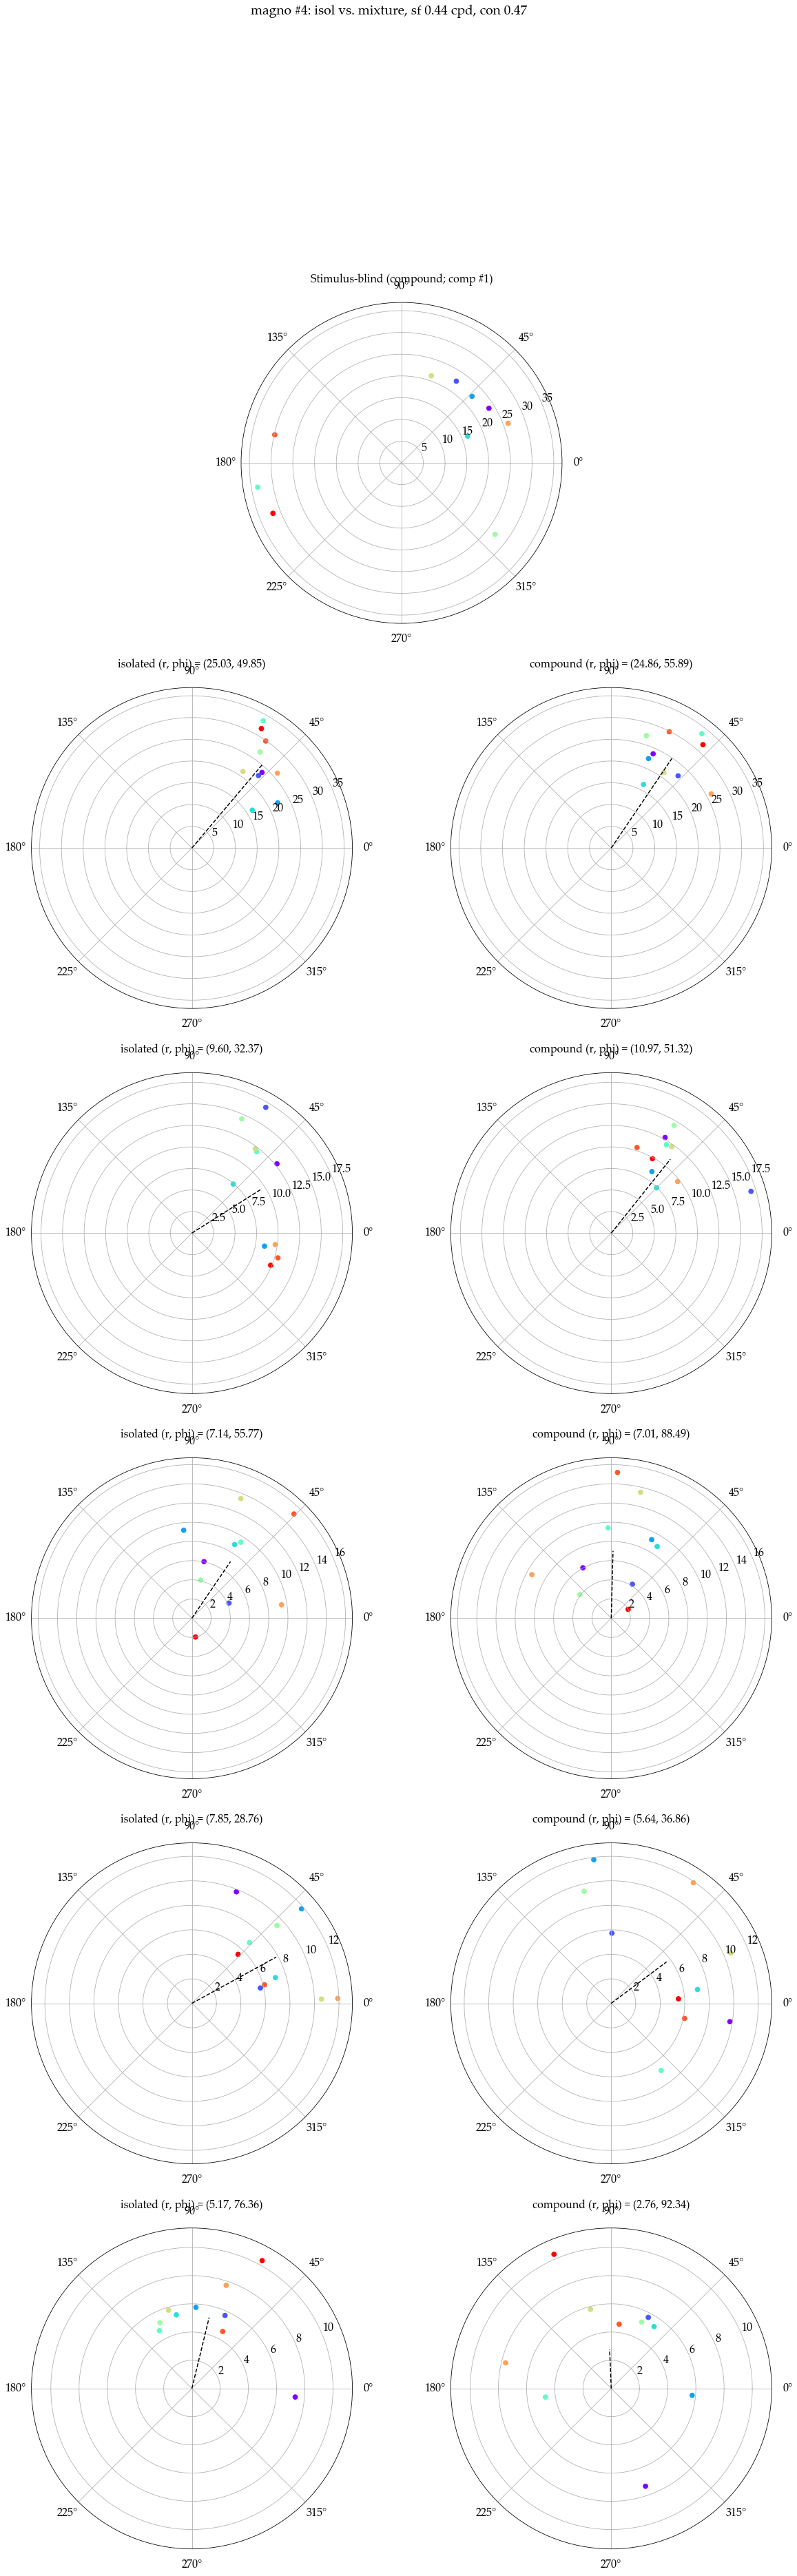

In [13]:
nrow = 1+nComp;
ncol = 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*10))

# in-mixture response phase - NOT stimulus-aligned
colors = cm.rainbow(np.linspace(0, 1, len(val_trials[0])))
ax = plt.subplot(nrow, 1, 1, projection='polar') # pretend only one column, i.e. take up whole top row
ax.scatter(np.radians(resp_phase_adj[0]), hf.flatten(f1all[0]), s=45, color=colors, clip_on=False);
ax.set_ylim([0, 1.1*np.max(hf.flatten(f1all[0]))]);
ax.set_title('Stimulus-blind (compound; comp #1)');

for i in range(nComp):

    # compute the isolated response
    # Then, pick one of the components and get the response (when presented in isolation) 
    # phases/amplitudes and align relative to the stimulus phase
    isolConInd = np.where(allCons == conByComp[i])[0][0]; # unwrap fully (will be only one value...)
    isolSfInd = np.where(allSfs == sfByComp[i])[0][0];
    val_trials_isol, _, _, _ = hf.get_valid_trials(cellStruct, disp=0, con=isolConInd, sf=isolSfInd)

    ph_rel_stim_isol, stim_phase_isol, resp_phase_isol, all_tf_isol = helper_fcns.get_true_phase(data, val_trials_isol, dir=dir);
    psth_val, _ = helper_fcns.make_psth(data['spikeTimes'][val_trials_isol])
    _, rel_amp_isol, _ = helper_fcns.spike_fft(psth_val, all_tf_isol)
    # and compute vector mean
    r_isol, th_isol, _, _ = helper_fcns.polar_vec_mean([rel_amp_isol], [ph_rel_stim_isol]);
    
    # isolated response phase - relative to stimulus phase
    colors = cm.rainbow(np.linspace(0, 1, len(val_trials[0])))
    ax = plt.subplot(nrow, ncol, 2*(i+1) + 1, projection='polar')
    ax.scatter(np.radians(ph_rel_stim_isol), rel_amp_isol, s=45, color=colors, clip_on=False);
    ax.plot([0, np.radians(th_isol[0])], [0, r_isol[0]], ls='--', color='k');
    ax.set_ylim([0, 1.1*np.max(rel_amp_isol)]);
    ax.set_title('isolated (r, phi) = (%.2f, %.2f)' % (r_isol[0], th_isol[0]));

    # in-mixture response phase - relative to stimulus phase
    colors = cm.rainbow(np.linspace(0, 1, len(val_trials[0])))
    ax = plt.subplot(nrow, ncol, 2*(i+2), projection='polar')
    ax.scatter(np.radians(ph_rel_stim_adj[i]), hf.flatten(f1all[i]), s=45, color=colors, clip_on=False);
    ax.plot([0, np.radians(th_comp[i])], [0, r_comp[i]], ls='--', color='k');
    ax.set_ylim([0, 1.1*np.max(rel_amp_isol)]);
    ax.set_title('compound (r, phi) = (%.2f, %.2f)' % (r_comp[i], th_comp[i]));

f.suptitle('%s #%d: isol vs. mixture, sf %.2f cpd, con %.2f' % (dataList['unitType'][cellNum-1], cellNum, allSfs[sf], allCons[con]));
